In [9]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice

def k_shortest_paths(G, source, target, k):
    """
    Finds the k shortest paths between two nodes.
    """
    return list(islice(nx.shortest_simple_paths(G, source, target), k))

def create_graph(edges, capacity):
    """
    Creates a directed graph from the given edges.
    """
    G = nx.DiGraph()
    for (i, j) in edges:
        G.add_edge(i, j, capacity=capacity[(i, j)])
    return G

def create_evacuation_model(edges, passengers, capacity, base_travel_time, K=50):
    """
    Creates an evacuation optimization model.
    """
    G = create_graph(edges, capacity)
    
    model = pyo.ConcreteModel()
    
    all_nodes = set([i for (i, j) in edges] + [j for (i, j) in edges])
    start_nodes = sorted(set(n for n in all_nodes if n.startswith('Başlangıç')))
    end_nodes = sorted(set(n for n in all_nodes if n.startswith('Bit')))
    
    model.edges = pyo.Set(initialize=edges)
    model.baslangic_nodes = pyo.Set(initialize=start_nodes)
    model.bitis_nodes = pyo.Set(initialize=end_nodes)
    
    paths = {}
    for s in start_nodes:
        for t in end_nodes:
            try:
                paths[(s, t)] = k_shortest_paths(G, s, t, K)
            except:
                continue
    
    model.paths = pyo.Set(initialize=[(s, t, k) for (s, t) in paths.keys() 
                                      for k in range(len(paths[(s, t)]))])
    
    model.edge_flow = pyo.Var(model.edges, domain=pyo.NonNegativeIntegers)
    model.path_flow = pyo.Var(model.paths, domain=pyo.NonNegativeIntegers)
    model.travel_time = pyo.Var(model.edges, domain=pyo.NonNegativeReals)
    
    # Objective function
    def objective_rule(model):
        return sum(model.edge_flow[e] * model.travel_time[e] for e in model.edges)
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)
    
    # Constraints
    def demand_rule(model, s):
        return sum(model.path_flow[s, t, k] for t in model.bitis_nodes 
                   for k in range(len(paths.get((s, t), [])))
                   if (s, t, k) in model.paths) == passengers[s]
    model.demand = pyo.Constraint(model.baslangic_nodes, rule=demand_rule)
    
    def capacity_rule(model, i, j):
        return model.edge_flow[i, j] <= capacity[(i, j)]
    model.capacity = pyo.Constraint(model.edges, rule=capacity_rule)
    
    def flow_conservation(model, i, j):
        edge_flow = model.edge_flow[i, j]
        path_sum = sum(model.path_flow[s, t, k] 
                       for (s, t, k) in model.paths 
                       if (i, j) in zip(paths[(s, t)][k][:-1], paths[(s, t)][k][1:]))
        return edge_flow == path_sum
    model.flow_conservation = pyo.Constraint(model.edges, rule=flow_conservation)
    
    def travel_time_rule(model, i, j):
        return model.travel_time[i, j] == base_travel_time[(i, j)] * (1 + 2 * (model.edge_flow[i, j] / capacity[(i, j)])**2)
    model.travel_time_constraint = pyo.Constraint(model.edges, rule=travel_time_rule)
    
    return model, paths, G

def solve_model(model, base_time_dict, cap_dict):
    """
    Solves the NLP model and produces integer solutions.
    Also uses provided dictionaries to update travel times.
    """
    solver = pyo.SolverFactory('ipopt')
    solver.options['max_iter'] = 10000
    solver.options['tol'] = 1e-6
    solver.options['print_level'] = 4  # For more detailed output
    
    # First solution
    results = solver.solve(model, tee=True)

    # Round flows to integers
    for edge in model.edges:
        current_flow = pyo.value(model.edge_flow[edge])
        model.edge_flow[edge].set_value(round(current_flow))

    for path in model.paths:
        current_flow = pyo.value(model.path_flow[path])
        model.path_flow[path].set_value(round(current_flow))

    # Update travel times
    for i, j in model.edges:
        current_flow = pyo.value(model.edge_flow[i, j])
        base_time = base_time_dict[(i, j)]
        cap = cap_dict[(i, j)]
        new_time = base_time * (1 + 1 * (current_flow / cap)**1)
        model.travel_time[i, j].set_value(new_time)

    return results


In [53]:
import random
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def print_results(model, edges, capacity, G, paths):
    """
    Display and visualize the results.
    """
    print("\n==================== RESULTS ====================")
    print(f"Objective Value: {pyo.value(model.objective):.2f}")
    
    # Print Edge Flow Table
    print("\nEDGE FLOWS AND TRAVEL TIMES:")
    print("-" * 60)
    print(f"{'Edge':<20} {'Flow':<10} {'Travel Time':<15} {'Capacity Usage':<15}")
    print("-" * 60)
    
    flow_values = {}
    total_flow = 0
    total_travel_time = 0
    total_capacity_usage = 0
    
    for (i, j) in edges:
        flow = int(round(pyo.value(model.edge_flow[i, j])))
        flow_values[(i, j)] = flow
        total_flow += flow
        time = pyo.value(model.travel_time[i, j])
        total_travel_time += time
        capacity_usage = (flow / capacity[(i, j)]) * 100
        total_capacity_usage += capacity_usage
        
        print(f"{i} -> {j:<15} {flow:<10} {time:<15.2f} {capacity_usage:<15.1f}")
    
    print("-" * 60)
    
    print("\nPATH FLOWS:")
    print("-" * 80)
    print(f"{'Source':<15} {'Target':<15} {'Path #':<5} {'Flow':>10} {'Time':>10}")
    print("-" * 80)
    
    path_times = []
    path_flow_weighted_times = []
    total_path_flows = []
    
    for s in model.baslangic_nodes:
        for t in model.bitis_nodes:
            for k in range(len(paths.get((s, t), []))):
                if (s, t, k) in model.path_flow:
                    flow = int(round(pyo.value(model.path_flow[s, t, k])))
                    if flow > 0:
                        total_path_flows.append(flow)
                        path = paths[(s, t)][k]
                        total_time = 0
                        individual_times = []
                        
                        for i in range(len(path) - 1):
                            edge = (path[i], path[i + 1])
                            edge_time = pyo.value(model.travel_time[edge])
                            total_time += edge_time
                            individual_times.append(edge_time)
                        
                        # Append path time and weighted flow*time for later calculations
                        path_times.append(total_time)
                        path_flow_weighted_times.append(flow * total_time)
                        
                        print(f"{s:<15} {t:<15} {k + 1:>5} {flow:>10} {total_time:>10.2f}")
                        print(f"    Path: {' -> '.join(path)}")
    
    if total_path_flows:
        max_path_time = max(path_times) if path_times else 0
        min_path_time = min(path_times) if path_times else 0
        total_path_flow = sum(total_path_flows)
        weighted_avg_time = (
            sum(path_flow_weighted_times) / total_path_flow if total_path_flow > 0 else 0
        )
        
        print("\nPATH TIME SUMMARY:")
        print(f"Minimum Path Time: {min_path_time:.2f}")
        print(f"Maximum Path Time: {max_path_time:.2f}")
        print(f"Flow-Weighted Average Path Time: {weighted_avg_time:.2f}")



def print_passenger_distribution(passengers):
    print("\n========= PASSENGER DISTRIBUTION AT START POINTS =========")
    print("-" * 50)
    print(f"{'Start Point':<20} {'Passenger Count':>15}")
    print("-" * 50) 
    
    total_passengers = 0
    for node, count in passengers.items():
        if node.startswith('Başlangıç') and count > 0:
            print(f"{node:<20} {count:>15,}")
            total_passengers += count
    
    print("-" * 50)
    print(f"{'TOTAL':<20} {total_passengers:>15,}")
    print("-" * 50)
    
    return total_passengers

def analyze_model(model, edges, capacity, stage_label):
    print(f"\n===== {stage_label} ANALYSIS =====")
    
    # Total flow amount
    total_flow = sum(pyo.value(model.edge_flow[e]) for e in edges)
    
    # Average travel time
    avg_travel_time = sum(pyo.value(model.travel_time[e]) for e in edges) / len(edges)
    
    # Capacity utilization rates
    max_utilization = 0
    most_congested_edge = None
    utilizations = []
    
    # Calculate total travel times
    total_travel_time = 0
    edge_travel_times = {}
    
    for e in edges:
        flow = pyo.value(model.edge_flow[e])
        travel_time = pyo.value(model.travel_time[e])
        cap = capacity[e]
        util = flow / cap if cap > 0 else 0
        utilizations.append(util)

        if util > max_utilization:
            max_utilization = util
            most_congested_edge = e
        
        # Total travel time for each edge
        edge_total_time = flow * travel_time
        edge_travel_times[e] = edge_total_time
        total_travel_time += edge_total_time

    # Print results
    print(f"Total Flow Amount: {total_flow}")
    print(f"Average Travel Time: {avg_travel_time:.2f}")
    print(f"Highest Capacity Utilization: {max_utilization*100:.1f}% (Edge: {most_congested_edge})")
    print(f"Total Travel Time for All Edges: {total_travel_time:.2f}")
    
    # Create histogram of capacity utilization rates
    plt.figure(figsize=(10, 6))
    plt.hist(utilizations, bins=20, color='blue', alpha=0.7)
    plt.title(f"{stage_label} - Capacity Utilization Distribution")
    plt.xlabel("Capacity Utilization Rate")
    plt.ylabel("Number of Edges")
    plt.grid(True)
    plt.show()


In [54]:
def visualize_two_stages(model1, edges1, capacity1, G1, model2, edges2, capacity2, G2):
    """
    Stage 1 ve Stage 2 ağlarını üst üste görselleştirir.
    Kenar renkleri kapasite kullanımına göre %25 aralıklarla değişir.
    Ara düğümler bağlantılarına bağlı olarak sola veya sağa kaydırılır.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    # Her aşama için gerekli parametreleri bir listeye toplayarak döngüyle işleyelim
    stages = [
        (ax1, model1, capacity1, G1, "Stage 1"),
        (ax2, model2, capacity2, G2, "Stage 2")
    ]
    
    for ax, model, capacity, G, stage_label in stages:
        # Genel konumlandırma için spring layout kullanımı
        pos = nx.spring_layout(G, seed=42)
        
        # Düğümleri kategorilere ayırma
        start_nodes = sorted(n for n in G.nodes() if n.startswith('Başlangıç'))
        finish_nodes = sorted(n for n in G.nodes() if n.startswith('Bit'))
        other_nodes = sorted(set(G.nodes()) - set(start_nodes) - set(finish_nodes))
        
        # Başlangıç düğümlerini hizalama (sol taraf)
        for i, node in enumerate(start_nodes):
            y = 1 - 2 * i / (len(start_nodes) - 1) if len(start_nodes) > 1 else 0
            pos[node] = (-1, y)
        
        # Bitiş düğümlerini hizalama (sağ taraf)
        for i, node in enumerate(finish_nodes):
            y = 1 - 2 * i / (len(finish_nodes) - 1) if len(finish_nodes) > 1 else 0
            pos[node] = (1, y)
        
        # Ara düğümleri hizalama (orta), bağlantılarına göre sola/sağa kaydırma
        for i, node in enumerate(other_nodes):
            y = 1 - 2 * i / (len(other_nodes) - 1) if len(other_nodes) > 1 else 0
            x_positions = []
            # Gelen kenarlar için sola kaydırma
            for pred in G.predecessors(node):
                if pred in other_nodes:
                    x_positions.append(-0.5)
            # Giden kenarlar için sağa kaydırma
            for succ in G.successors(node):
                if succ in other_nodes:
                    x_positions.append(0.5)
            x = sum(x_positions) / len(x_positions) if x_positions else 0
            pos[node] = (x, y)
        
        # Düğümleri çizme
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=300, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
        
        # Kenar renklerini akışa göre belirleme
        edge_colors = []
        for (u, v) in G.edges():
            # Akışı güvenli bir şekilde al
            try:
                flow = pyo.value(model.edge_flow[u, v])
            except KeyError:
                flow = 0
            cap = capacity.get((u, v), None)
            ratio = flow / cap if cap and cap > 0 else 0
            
            # Kapasite kullanımına göre kenar rengini belirle
            if ratio <= 0.25:
                edge_colors.append('green')
            elif ratio <= 0.5:
                edge_colors.append('yellow')
            elif ratio <= 0.75:
                edge_colors.append('orange')
            else:
                edge_colors.append('red')
        
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, arrowsize=10)
        ax.set_title(stage_label)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


In [55]:
def create_stage_two_network(original_total_passengers):
    new_passengers = {}
    
    # Rastgele oranlar oluştur
    oranlar = np.random.dirichlet(np.ones(len(baslangic_noktalari)))
    
    # Toplam yolcu sayısını oranlara göre dağıt
    for i, nokta in enumerate(baslangic_noktalari):
        new_passengers[nokta] = int(original_total_passengers * oranlar[i])
    
    # Yuvarlama hatalarını düzelt
    toplam = sum(new_passengers.values())
    if toplam != original_total_passengers:
        fark = original_total_passengers - toplam
        new_passengers[baslangic_noktalari[0]] += fark
    
    return new_edges, new_travel_time, new_capacity, new_passengers
    
def run_two_stage_optimization():
    # AŞAMA 1
    print("STAGE 1 -")
    print("-------------------------")
    toplam_yolcu = print_passenger_distribution(passengers)
    model1, paths1, G1 = create_evacuation_model(edges, passengers, capacity, travel_time)
    results1 = solve_model(model1, travel_time, capacity)
    if results1:
        print_results(model1, edges, capacity, G1, paths1)
        analyze_model(model1, edges, capacity, "Stage 1")
    
    # AŞAMA 2
    print("\STAGE 2 ")
    print("-------------------------")
    new_edges, new_travel_time, new_capacity, new_passengers = create_stage_two_network(toplam_yolcu)
    print_passenger_distribution(new_passengers)
    model2, paths2, G2 = create_evacuation_model(new_edges, new_passengers, new_capacity, new_travel_time)
    results2 = solve_model(model2, new_travel_time, new_capacity)
    if results2:
        print_results(model2, new_edges, new_capacity, G2, paths2)
        analyze_model(model2, new_edges, new_capacity, "Stage 2")
    
    visualize_two_stages(model1, edges, capacity, G1, model2, new_edges, new_capacity, G2)


# Modeli çalıştır
# if __name__ == "__main__":
#     run_two_stage_optimization()


## TestCase1

In [56]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"),
    ("Başlangıç2", "Ara11"),
    ("Başlangıç3", "Ara13"),
    ("Başlangıç3", "Ara12"),
    ("Başlangıç3", "Başlangıç4"),
    ("Başlangıç4", "Başlangıç3"),
    ("Başlangıç4", "Başlangıç5"),
    ("Başlangıç5", "Ara13"),
    ("Başlangıç5", "Başlangıç4"),
    ("Başlangıç6", "Ara14"),
    ("Başlangıç6", "Başlangıç7"),
    ("Başlangıç7", "Başlangıç6"),
    ("Başlangıç8", "Ara21"),
    ("Başlangıç9", "Ara24"),

    # Intermediate connections
    ("Ara10", "Ara16"),
    ("Ara11", "Ara10"),
    ("Ara11", "Ara12"),
    ("Ara11", "Ara17"),
    ("Ara12", "Ara18"),
    ("Ara13", "Ara14"),
    ("Ara13", "Ara19"),
    ("Ara14", "Ara15"),
    ("Ara15", "Ara20"),
    ("Ara15", "Ara35"),
    ("Ara16", "Ara28"),
    ("Ara17", "Ara16"),
    ("Ara17", "Ara18"),
    ("Ara18", "Ara19"),
    ("Ara19", "Ara20"),
    ("Ara20", "Ara34"),
    ("Ara21", "Ara22"),
    ("Ara21", "Ara35"),
    ("Ara22", "Ara23"),
    ("Ara22", "Bit45"),
    ("Ara23", "Bit46"),
    ("Ara24", "Ara25"),
    ("Ara24", "Ara36"),
    ("Ara25", "Ara26"),
    ("Ara25", "Ara37"),
    ("Ara26", "Ara27"),
    ("Ara26", "Ara38"),
    ("Ara27", "Ara39"),
    ("Ara28", "Bit29"),
    ("Ara28", "Bit50"),
    ("Ara32", "Bit31"),
    ("Ara32", "Bit40"),
    ("Ara33", "Ara32"),
    ("Ara33", "Bit41"),
    ("Ara34", "Bit42"),
    ("Ara34", "Ara33"),
    ("Ara35", "Ara34"),
    ("Ara35", "Bit44"),
    ("Ara36", "Ara37"),
    ("Ara36", "Bit47"),
    ("Ara37", "Ara38"),
    ("Ara37", "Bit48"),
    ("Ara38", "Ara39"),
    ("Ara39", "Bit49"),
]

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 32.4,
    ("Başlangıç2", "Ara11"): 18,
    ("Başlangıç3", "Ara13"): 21.6,
    ("Başlangıç3", "Ara12"): 19.8,
    ("Başlangıç3", "Başlangıç4"): 0,
    ("Başlangıç4", "Başlangıç3"): 0,
    ("Başlangıç4", "Başlangıç5"): 0,
    ("Başlangıç5", "Ara13"): 37.8,
    ("Başlangıç5", "Başlangıç4"): 0,
    ("Başlangıç6", "Ara14"): 27,
    ("Başlangıç6", "Başlangıç7"): 0,
    ("Başlangıç7", "Başlangıç6"): 0,
    ("Başlangıç8", "Ara21"): 63,
    ("Başlangıç9", "Ara24"): 34.2,

    # Intermediate connections
    ("Ara10", "Ara16"): 43.2,
    ("Ara11", "Ara10"): 77.4,
    ("Ara11", "Ara12"): 68,
    ("Ara11", "Ara17"): 18,
    ("Ara12", "Ara18"): 27,
    ("Ara13", "Ara14"): 54,
    ("Ara13", "Ara19"): 34.2,
    ("Ara14", "Ara15"): 10.8,
    ("Ara15", "Ara20"): 21.6,
    ("Ara15", "Ara35"): 55.8,
    ("Ara16", "Ara28"): 176.4,
    ("Ara17", "Ara16"): 14,
    ("Ara17", "Ara18"): 12,
    ("Ara18", "Ara19"): 27,
    ("Ara19", "Ara20"): 66.6,
    ("Ara20", "Ara34"): 46.8,
    ("Ara21", "Ara22"): 41.4,
    ("Ara21", "Ara35"): 18,
    ("Ara22", "Ara23"): 32.4,
    ("Ara22", "Bit45"): 81,
    ("Ara23", "Bit46"): 77.4,
    ("Ara24", "Ara25"): 21.6,
    ("Ara24", "Ara36"): 25.2,
    ("Ara25", "Ara26"): 52.2,
    ("Ara25", "Ara37"): 25.2,
    ("Ara26", "Ara27"): 48.6,
    ("Ara26", "Ara38"): 25.2,
    ("Ara27", "Ara39"): 28.8,
    ("Ara28", "Bit29"): 50.4,
    ("Ara28", "Bit50"): 45,
    ("Ara32", "Bit31"): 19.8,
    ("Ara32", "Bit40"): 27,
    ("Ara33", "Ara32"): 10.8,
    ("Ara33", "Bit41"): 32.4,
    ("Ara34", "Bit42"): 45,
    ("Ara34", "Ara33"): 63,
    ("Ara35", "Ara34"): 48.6,
    ("Ara35", "Bit44"): 100.8,
    ("Ara36", "Ara37"): 21.6,
    ("Ara36", "Bit47"): 70.2,
    ("Ara37", "Ara38"): 18,
    ("Ara37", "Bit48"): 25,
    ("Ara38", "Ara39"): 50.4,
    ("Ara39", "Bit49"): 52.2,
}

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 4400,
    ("Başlangıç2", "Ara11"): 2200,
    ("Başlangıç3", "Ara13"): 2200,
    ("Başlangıç3", "Ara12"): 6600,
    ("Başlangıç3", "Başlangıç4"): 100000,
    ("Başlangıç4", "Başlangıç3"): 100000,
    ("Başlangıç4", "Başlangıç5"): 100000,
    ("Başlangıç5", "Ara13"): 4400,
    ("Başlangıç5", "Başlangıç4"): 100000,
    ("Başlangıç6", "Ara14"): 6600,
    ("Başlangıç6", "Başlangıç7"): 100000,
    ("Başlangıç7", "Başlangıç6"): 100000,
    ("Başlangıç8", "Ara21"): 4400,
    ("Başlangıç9", "Ara24"): 6600,

    # Intermediate connections
    ("Ara10", "Ara16"): 4400,
    ("Ara11", "Ara10"): 4400,
    ("Ara11", "Ara12"): 4400,
    ("Ara11", "Ara17"): 2200,
    ("Ara12", "Ara18"): 2200,
    ("Ara13", "Ara14"): 6600,
    ("Ara13", "Ara19"): 4400,
    ("Ara14", "Ara15"): 8800,
    ("Ara15", "Ara20"): 4400,
    ("Ara15", "Ara35"): 6600,
    ("Ara16", "Ara28"): 6600,
    ("Ara17", "Ara16"): 4400,
    ("Ara17", "Ara18"): 6600,
    ("Ara18", "Ara19"): 6600,
    ("Ara19", "Ara20"): 6600,
    ("Ara20", "Ara34"): 8800,
    ("Ara21", "Ara22"): 6600,
    ("Ara21", "Ara35"): 4400,
    ("Ara22", "Ara23"): 6600,
    ("Ara22", "Bit45"): 2200,
    ("Ara23", "Bit46"): 4400,
    ("Ara24", "Ara25"): 2200,
    ("Ara24", "Ara36"): 6600,
    ("Ara25", "Ara26"): 4400,
    ("Ara25", "Ara37"): 6600,
    ("Ara26", "Ara27"): 4400,
    ("Ara26", "Ara38"): 4400,
    ("Ara27", "Ara39"): 4400,
    ("Ara28", "Bit29"): 4400,
    ("Ara28", "Bit50"): 4400,
    ("Ara32", "Bit31"): 2200,
    ("Ara32", "Bit40"): 2200,
    ("Ara33", "Ara32"): 4400,
    ("Ara33", "Bit41"): 2200,
    ("Ara34", "Bit42"): 4400,
    ("Ara34", "Ara33"): 6600,
    ("Ara35", "Ara34"): 6600,
    ("Ara35", "Bit44"): 6600,
    ("Ara36", "Ara37"): 6600,
    ("Ara36", "Bit47"): 2200,
    ("Ara37", "Ara38"): 2200,
    ("Ara37", "Bit48"): 2200,
    ("Ara38", "Ara39"): 2200,
    ("Ara39", "Bit49"): 4400,
}

passengers = {
    "Başlangıç1": 2000,
    "Başlangıç2": 1000,
    "Başlangıç3": 2200,
    "Başlangıç4": 0,
    "Başlangıç5": 2800,
    "Başlangıç6": 3000,
    "Başlangıç7": 0,
    "Başlangıç8": 2000,
    "Başlangıç9": 3000,

    "Ara10": 0, "Ara11": 0, "Ara12": 0, "Ara13": 0, "Ara14": 0,
    "Ara15": 0, "Ara16": 0, "Ara17": 0, "Ara18": 0, "Ara19": 0,
    "Ara20": 0, "Ara21": 0, "Ara22": 0, "Ara23": 0, "Ara24": 0,
    "Ara25": 0, "Ara26": 0, "Ara27": 0, "Ara28": 0, "Bit29": 0,
    "Bit30": 0, "Bit31": 0, "Ara32": 0, "Ara33": 0, "Ara34": 0,
    "Ara35": 0, "Ara36": 0, "Ara37": 0, "Ara38": 0, "Ara39": 0,
    "Bit40": 0, "Bit41": 0, "Bit42": 0, "Bit43": 0, "Bit44": 0,
    "Bit45": 0, "Bit46": 0, "Bit47": 0, "Bit48": 0, "Bit49": 0,
    "Bit50": 0
}

In [57]:
# Yeni ağ yapısı
new_edges = [
    ('Başlangıç51', 'Başlangıç52'), ('Başlangıç51', 'Ara64'), 
    ('Başlangıç52', 'Başlangıç51'), ('Başlangıç52', 'Başlangıç56'), ('Başlangıç52', 'Ara64'),
    ('Başlangıç56', 'Başlangıç57'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç56', 'Ara65'),
    ('Başlangıç57', 'Başlangıç67'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç57', 'Ara66'),
    ('Başlangıç67', 'Başlangıç57'), ('Başlangıç67', 'Başlangıç68'), ('Başlangıç67', 'Ara76'),
    ('Başlangıç68', 'Başlangıç67'), ('Başlangıç68', 'Başlangıç70'), ('Başlangıç68', 'Ara77'),
    ('Başlangıç70', 'Başlangıç68'), ('Başlangıç70', 'Ara78'),
    ('Ara64', 'Ara65'), ('Ara64', 'Ara74'),
    ('Ara65', 'Ara66'), ('Ara65', 'Ara72'),
    ('Ara66', 'Ara73'), 
    ('Ara72', 'Ara73'), ('Ara72', 'Ara74'),
    ('Ara73', 'Ara75'),
    ('Ara74', 'Ara75'),
    ('Ara75', 'Ara76'), ('Ara75', 'Bit79'),
    ('Ara76', 'Ara77'), ('Ara76', 'Bit80'),
    ('Ara77', 'Ara78'),
    ('Ara78', 'Bit81'),
]

# Yeni seyahat süreleri
new_travel_time = {
    ('Başlangıç51', 'Başlangıç52'):0, ('Başlangıç51', 'Ara64'):90, 
    ('Başlangıç52', 'Başlangıç51'):0, ('Başlangıç52', 'Başlangıç56'):0, ('Başlangıç52', 'Ara64'): 36,
    ('Başlangıç56', 'Başlangıç57'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç56', 'Ara65'): 27,
    ('Başlangıç57', 'Başlangıç67'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç57', 'Ara66'): 34.20,
    ('Başlangıç67', 'Başlangıç57'):0, ('Başlangıç67', 'Başlangıç68'):0, ('Başlangıç67', 'Ara76'): 50.4,
    ('Başlangıç68', 'Başlangıç67'):0, ('Başlangıç68', 'Başlangıç70'):0, ('Başlangıç68', 'Ara77'): 68.4,
    ('Başlangıç70', 'Başlangıç68'):0, ('Başlangıç70', 'Ara78'): 72.00,
    ('Ara64', 'Ara65'): 86.4, ('Ara64', 'Ara74'): 90,
    ('Ara65', 'Ara66'): 79.2, ('Ara65', 'Ara72'): 14.4,
    ('Ara66', 'Ara73'): 23.4, 
    ('Ara72', 'Ara73'): 79.2, ('Ara72', 'Ara74'): 14.4,
    ('Ara73', 'Ara75'): 23.4,
    ('Ara74', 'Ara75'): 79.2,
    ('Ara75', 'Ara76'): 52.2, ('Ara75', 'Bit79'): 39.6,
    ('Ara76', 'Ara77'): 73.8, ('Ara76', 'Bit80'): 55.8,
    ('Ara77', 'Ara78'): 32.4,
    ('Ara78', 'Bit81'): 79.2,
}

# Yeni kapasiteler
new_capacity = {
    ('Başlangıç51', 'Başlangıç52'):1000000, ('Başlangıç51', 'Ara64'):2200, 
    ('Başlangıç52', 'Başlangıç51'):1000000, ('Başlangıç52', 'Başlangıç56'):1000000, ('Başlangıç52', 'Ara64'): 4400,
    ('Başlangıç56', 'Başlangıç57'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç56', 'Ara65'): 6600,
    ('Başlangıç57', 'Başlangıç67'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç57', 'Ara66'): 4400,
    ('Başlangıç67', 'Başlangıç57'):1000000, ('Başlangıç67', 'Başlangıç68'):1000000, ('Başlangıç67', 'Ara76'): 6600,
    ('Başlangıç68', 'Başlangıç67'):1000000, ('Başlangıç68', 'Başlangıç70'):1000000, ('Başlangıç68', 'Ara77'): 2200,
    ('Başlangıç70', 'Başlangıç68'):1000000, ('Başlangıç70', 'Ara78'): 6600,
    ('Ara64', 'Ara65'): 4400, ('Ara64', 'Ara74'): 4400,
    ('Ara65', 'Ara66'): 13200, ('Ara65', 'Ara72'): 6600,
    ('Ara66', 'Ara73'): 8800, 
    ('Ara72', 'Ara73'): 2200, ('Ara72', 'Ara74'): 4400,
    ('Ara73', 'Ara75'): 11000,
    ('Ara74', 'Ara75'): 6600,
    ('Ara75', 'Ara76'): 6600, ('Ara75', 'Bit79'): 11000,
    ('Ara76', 'Ara77'): 2200, ('Ara76', 'Bit80'): 11000,
    ('Ara77', 'Ara78'): 4400,
    ('Ara78', 'Bit81'): 11000,
}

# Yeni yolcu dağılımı - Daha güvenli yöntem
baslangic_noktalari = ['Başlangıç51', 'Başlangıç52', 'Başlangıç56', 'Başlangıç57', 'Başlangıç67', 'Başlangıç68', 'Başlangıç70']


STAGE 1 -
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç1                     2,000
Başlangıç2                     1,000
Başlangıç3                     2,200
Başlangıç5                     2,800
Başlangıç6                     3,000
Başlangıç8                     2,000
Başlangıç9                     3,000
--------------------------------------------------
TOTAL                         16,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 194 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
 

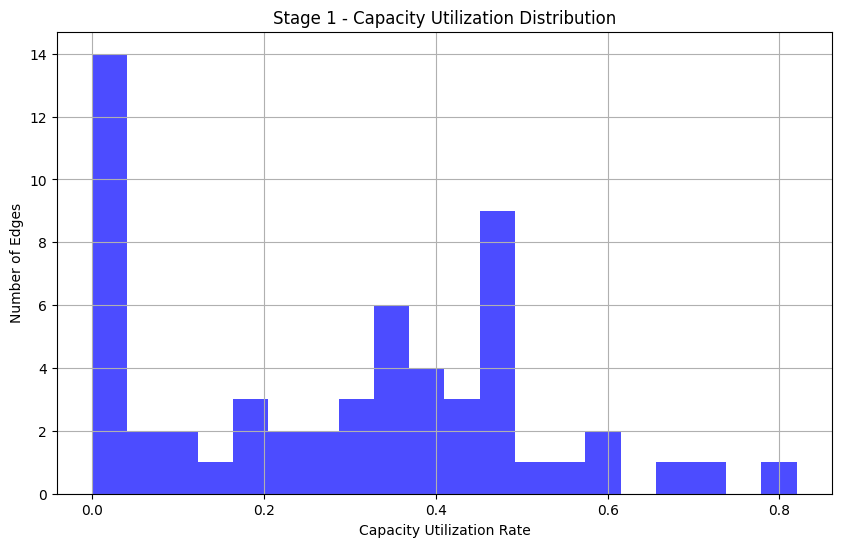

\STAGE 2 
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç51                      393
Başlangıç52                    1,478
Başlangıç56                    6,158
Başlangıç57                    3,030
Başlangıç67                      831
Başlangıç68                    2,319
Başlangıç70                    1,791
--------------------------------------------------
TOTAL                         16,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 193 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
 

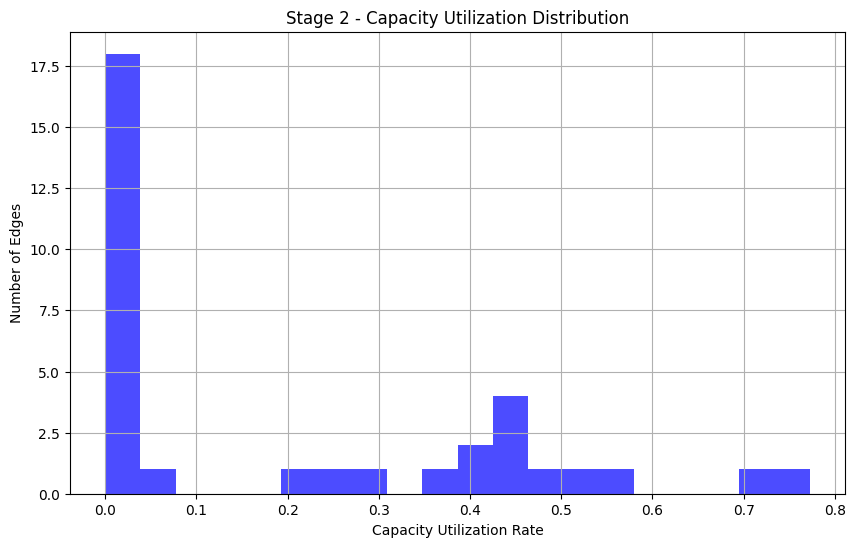

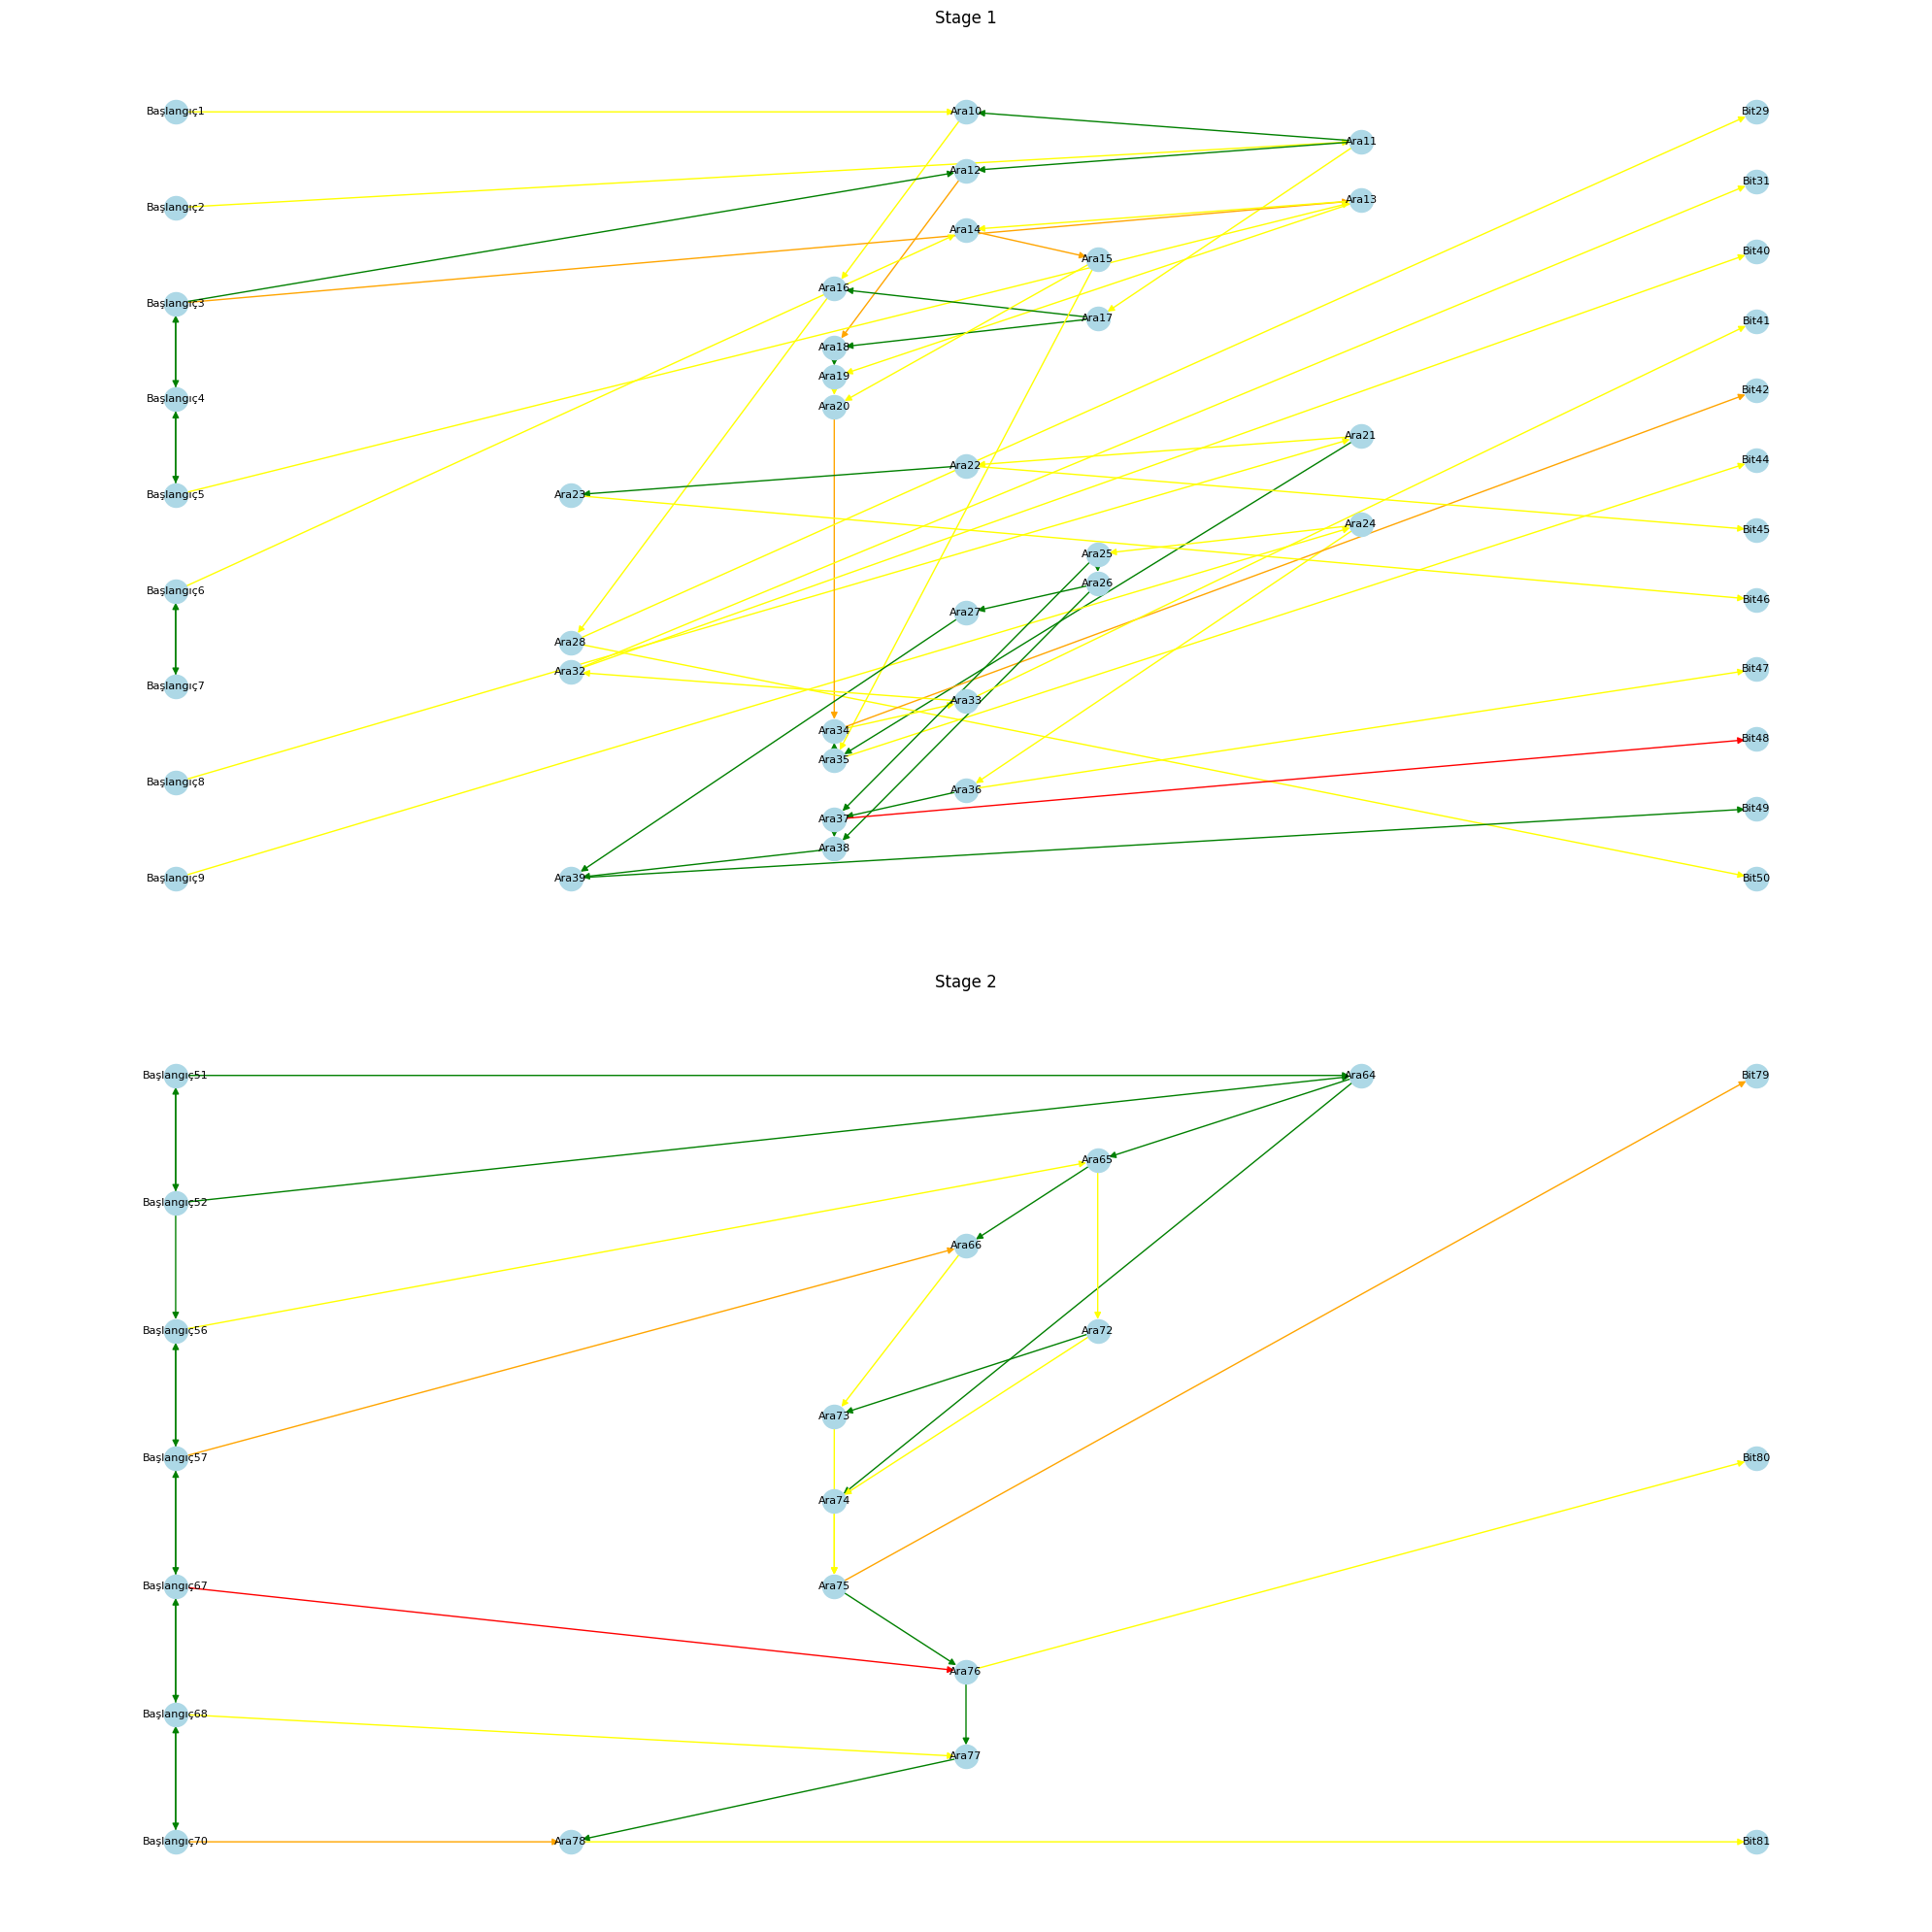

In [58]:
run_two_stage_optimization()

## TestCase2

In [18]:
edges = [
    ("Başlangıç1", "Ara10"),
    ("Başlangıç2", "Ara11"),
    ("Başlangıç3", "Ara13"),
    ("Başlangıç3", "Ara12"),
    ("Başlangıç3", "Başlangıç4"),
    ("Başlangıç4", "Başlangıç3"),
    ("Başlangıç4", "Başlangıç5"),
    ("Başlangıç5", "Ara13"),
    ("Başlangıç5", "Başlangıç4"),
    ("Başlangıç6", "Ara14"),
    ("Başlangıç6", "Başlangıç7"),
    ("Başlangıç7", "Başlangıç6"),
    ("Başlangıç8", "Ara21"),
    ("Başlangıç9", "Ara24"),

    # Intermediate connections
    ("Ara10", "Ara16"),
    ("Ara11", "Ara10"),
    ("Ara11", "Ara12"),
    ("Ara11", "Ara17"),
    ("Ara12", "Ara18"),
    ("Ara13", "Ara14"),
    ("Ara13", "Ara19"),
    ("Ara14", "Ara15"),
    ("Ara15", "Ara20"),
    ("Ara15", "Ara35"),
    ("Ara16", "Ara28"),
    ("Ara17", "Ara16"),
    ("Ara17", "Ara18"),
    ("Ara18", "Ara19"),
    ("Ara19", "Ara20"),
    ("Ara20", "Ara34"),
    ("Ara21", "Ara22"),
    ("Ara21", "Ara35"),
    ("Ara22", "Ara23"),
    ("Ara22", "Bit45"),
    ("Ara23", "Bit46"),
    ("Ara24", "Ara25"),
    ("Ara24", "Ara36"),
    ("Ara25", "Ara26"),
    ("Ara25", "Ara37"),
    ("Ara26", "Ara27"),
    ("Ara26", "Ara38"),
    ("Ara27", "Ara39"),
    ("Ara28", "Bit29"),
    ("Ara28", "Bit50"),
    ("Ara32", "Bit31"),
    ("Ara32", "Bit40"),
    ("Ara33", "Ara32"),
    ("Ara33", "Bit41"),
    ("Ara34", "Bit42"),
    ("Ara34", "Ara33"),
    ("Ara35", "Ara34"),
    ("Ara35", "Bit44"),
    ("Ara36", "Ara37"),
    ("Ara36", "Bit47"),
    ("Ara37", "Ara38"),
    ("Ara37", "Bit48"),
    ("Ara38", "Ara39"),
    ("Ara39", "Bit49"),
]

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 32.4,
    ("Başlangıç2", "Ara11"): 18,
    ("Başlangıç3", "Ara13"): 21.6,
    ("Başlangıç3", "Ara12"): 19.8,
    ("Başlangıç3", "Başlangıç4"): 0,
    ("Başlangıç4", "Başlangıç3"): 0,
    ("Başlangıç4", "Başlangıç5"): 0,
    ("Başlangıç5", "Ara13"): 37.8,
    ("Başlangıç5", "Başlangıç4"): 0,
    ("Başlangıç6", "Ara14"): 27,
    ("Başlangıç6", "Başlangıç7"): 0,
    ("Başlangıç7", "Başlangıç6"): 0,
    ("Başlangıç8", "Ara21"): 63,
    ("Başlangıç9", "Ara24"): 34.2,

    # Intermediate connections
    ("Ara10", "Ara16"): 43.2,
    ("Ara11", "Ara10"): 77.4,
    ("Ara11", "Ara12"): 68,
    ("Ara11", "Ara17"): 18,
    ("Ara12", "Ara18"): 27,
    ("Ara13", "Ara14"): 54,
    ("Ara13", "Ara19"): 34.2,
    ("Ara14", "Ara15"): 10.8,
    ("Ara15", "Ara20"): 21.6,
    ("Ara15", "Ara35"): 55.8,
    ("Ara16", "Ara28"): 176.4,
    ("Ara17", "Ara16"): 14,
    ("Ara17", "Ara18"): 12,
    ("Ara18", "Ara19"): 27,
    ("Ara19", "Ara20"): 66.6,
    ("Ara20", "Ara34"): 46.8,
    ("Ara21", "Ara22"): 41.4,
    ("Ara21", "Ara35"): 18,
    ("Ara22", "Ara23"): 32.4,
    ("Ara22", "Bit45"): 81,
    ("Ara23", "Bit46"): 77.4,
    ("Ara24", "Ara25"): 21.6,
    ("Ara24", "Ara36"): 25.2,
    ("Ara25", "Ara26"): 52.2,
    ("Ara25", "Ara37"): 25.2,
    ("Ara26", "Ara27"): 48.6,
    ("Ara26", "Ara38"): 25.2,
    ("Ara27", "Ara39"): 28.8,
    ("Ara28", "Bit29"): 50.4,
    ("Ara28", "Bit50"): 45,
    ("Ara32", "Bit31"): 19.8,
    ("Ara32", "Bit40"): 27,
    ("Ara33", "Ara32"): 10.8,
    ("Ara33", "Bit41"): 32.4,
    ("Ara34", "Bit42"): 45,
    ("Ara34", "Ara33"): 63,
    ("Ara35", "Ara34"): 48.6,
    ("Ara35", "Bit44"): 100.8,
    ("Ara36", "Ara37"): 21.6,
    ("Ara36", "Bit47"): 70.2,
    ("Ara37", "Ara38"): 18,
    ("Ara37", "Bit48"): 25,
    ("Ara38", "Ara39"): 50.4,
    ("Ara39", "Bit49"): 52.2,
}

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 4400,
    ("Başlangıç2", "Ara11"): 2200,
    ("Başlangıç3", "Ara13"): 2200,
    ("Başlangıç3", "Ara12"): 6600,
    ("Başlangıç3", "Başlangıç4"): 100000,
    ("Başlangıç4", "Başlangıç3"): 100000,
    ("Başlangıç4", "Başlangıç5"): 100000,
    ("Başlangıç5", "Ara13"): 4400,
    ("Başlangıç5", "Başlangıç4"): 100000,
    ("Başlangıç6", "Ara14"): 6600,
    ("Başlangıç6", "Başlangıç7"): 100000,
    ("Başlangıç7", "Başlangıç6"): 100000,
    ("Başlangıç8", "Ara21"): 4400,
    ("Başlangıç9", "Ara24"): 6600,

    # Intermediate connections
    ("Ara10", "Ara16"): 4400,
    ("Ara11", "Ara10"): 4400,
    ("Ara11", "Ara12"): 4400,
    ("Ara11", "Ara17"): 2200,
    ("Ara12", "Ara18"): 2200,
    ("Ara13", "Ara14"): 6600,
    ("Ara13", "Ara19"): 4400,
    ("Ara14", "Ara15"): 8800,
    ("Ara15", "Ara20"): 4400,
    ("Ara15", "Ara35"): 6600,
    ("Ara16", "Ara28"): 6600,
    ("Ara17", "Ara16"): 4400,
    ("Ara17", "Ara18"): 6600,
    ("Ara18", "Ara19"): 6600,
    ("Ara19", "Ara20"): 6600,
    ("Ara20", "Ara34"): 8800,
    ("Ara21", "Ara22"): 6600,
    ("Ara21", "Ara35"): 4400,
    ("Ara22", "Ara23"): 6600,
    ("Ara22", "Bit45"): 2200,
    ("Ara23", "Bit46"): 4400,
    ("Ara24", "Ara25"): 2200,
    ("Ara24", "Ara36"): 6600,
    ("Ara25", "Ara26"): 4400,
    ("Ara25", "Ara37"): 6600,
    ("Ara26", "Ara27"): 4400,
    ("Ara26", "Ara38"): 4400,
    ("Ara27", "Ara39"): 4400,
    ("Ara28", "Bit29"): 4400,
    ("Ara28", "Bit50"): 4400,
    ("Ara32", "Bit31"): 2200,
    ("Ara32", "Bit40"): 2200,
    ("Ara33", "Ara32"): 4400,
    ("Ara33", "Bit41"): 2200,
    ("Ara34", "Bit42"): 4400,
    ("Ara34", "Ara33"): 6600,
    ("Ara35", "Ara34"): 6600,
    ("Ara35", "Bit44"): 6600,
    ("Ara36", "Ara37"): 6600,
    ("Ara36", "Bit47"): 2200,
    ("Ara37", "Ara38"): 2200,
    ("Ara37", "Bit48"): 2200,
    ("Ara38", "Ara39"): 2200,
    ("Ara39", "Bit49"): 4400,
}

passengers = {
    "Başlangıç1": 4400,
    "Başlangıç2": 2200,
    "Başlangıç3": 4400,
    "Başlangıç4": 0,
    "Başlangıç5": 4400,
    "Başlangıç6": 3300,
    "Başlangıç7": 3300,
    "Başlangıç8": 4400,
    "Başlangıç9": 6600,

    "Ara10": 0, "Ara11": 0, "Ara12": 0, "Ara13": 0, "Ara14": 0,
    "Ara15": 0, "Ara16": 0, "Ara17": 0, "Ara18": 0, "Ara19": 0,
    "Ara20": 0, "Ara21": 0, "Ara22": 0, "Ara23": 0, "Ara24": 0,
    "Ara25": 0, "Ara26": 0, "Ara27": 0, "Ara28": 0, "Bit29": 0,
    "Bit30": 0, "Bit31": 0, "Ara32": 0, "Ara33": 0, "Ara34": 0,
    "Ara35": 0, "Ara36": 0, "Ara37": 0, "Ara38": 0, "Ara39": 0,
    "Bit40": 0, "Bit41": 0, "Bit42": 0, "Bit43": 0, "Bit44": 0,
    "Bit45": 0, "Bit46": 0, "Bit47": 0, "Bit48": 0, "Bit49": 0,
    "Bit50": 0
}

In [19]:
# Yeni ağ yapısı
new_edges = [
    ('Başlangıç51', 'Başlangıç52'), ('Başlangıç51', 'Ara64'), 
    ('Başlangıç52', 'Başlangıç51'), ('Başlangıç52', 'Başlangıç56'), ('Başlangıç52', 'Ara64'),
    ('Başlangıç56', 'Başlangıç57'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç56', 'Ara65'),
    ('Başlangıç57', 'Başlangıç67'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç57', 'Ara66'),
    ('Başlangıç67', 'Başlangıç57'), ('Başlangıç67', 'Başlangıç68'), ('Başlangıç67', 'Ara76'),
    ('Başlangıç68', 'Başlangıç67'), ('Başlangıç68', 'Başlangıç70'), ('Başlangıç68', 'Ara77'),
    ('Başlangıç70', 'Başlangıç68'), ('Başlangıç70', 'Ara78'),
    ('Ara64', 'Ara65'), ('Ara64', 'Ara74'),
    ('Ara65', 'Ara66'), ('Ara65', 'Ara72'),
    ('Ara66', 'Ara73'), 
    ('Ara72', 'Ara73'), ('Ara72', 'Ara74'),
    ('Ara73', 'Ara75'),
    ('Ara74', 'Ara75'),
    ('Ara75', 'Ara76'), ('Ara75', 'Bit79'),
    ('Ara76', 'Ara77'), ('Ara76', 'Bit80'),
    ('Ara77', 'Ara78'),
    ('Ara78', 'Bit81'),
]

# Yeni seyahat süreleri
new_travel_time = {
    ('Başlangıç51', 'Başlangıç52'):0, ('Başlangıç51', 'Ara64'):90, 
    ('Başlangıç52', 'Başlangıç51'):0, ('Başlangıç52', 'Başlangıç56'):0, ('Başlangıç52', 'Ara64'): 36,
    ('Başlangıç56', 'Başlangıç57'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç56', 'Ara65'): 27,
    ('Başlangıç57', 'Başlangıç67'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç57', 'Ara66'): 34.20,
    ('Başlangıç67', 'Başlangıç57'):0, ('Başlangıç67', 'Başlangıç68'):0, ('Başlangıç67', 'Ara76'): 50.4,
    ('Başlangıç68', 'Başlangıç67'):0, ('Başlangıç68', 'Başlangıç70'):0, ('Başlangıç68', 'Ara77'): 68.4,
    ('Başlangıç70', 'Başlangıç68'):0, ('Başlangıç70', 'Ara78'): 72.00,
    ('Ara64', 'Ara65'): 86.4, ('Ara64', 'Ara74'): 90,
    ('Ara65', 'Ara66'): 79.2, ('Ara65', 'Ara72'): 14.4,
    ('Ara66', 'Ara73'): 23.4, 
    ('Ara72', 'Ara73'): 79.2, ('Ara72', 'Ara74'): 14.4,
    ('Ara73', 'Ara75'): 23.4,
    ('Ara74', 'Ara75'): 79.2,
    ('Ara75', 'Ara76'): 52.2, ('Ara75', 'Bit79'): 39.6,
    ('Ara76', 'Ara77'): 73.8, ('Ara76', 'Bit80'): 55.8,
    ('Ara77', 'Ara78'): 32.4,
    ('Ara78', 'Bit81'): 79.2,
}

# Yeni kapasiteler
new_capacity = {
    ('Başlangıç51', 'Başlangıç52'):1000000, ('Başlangıç51', 'Ara64'):2200, 
    ('Başlangıç52', 'Başlangıç51'):1000000, ('Başlangıç52', 'Başlangıç56'):1000000, ('Başlangıç52', 'Ara64'): 4400,
    ('Başlangıç56', 'Başlangıç57'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç56', 'Ara65'): 6600,
    ('Başlangıç57', 'Başlangıç67'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç57', 'Ara66'): 4400,
    ('Başlangıç67', 'Başlangıç57'):1000000, ('Başlangıç67', 'Başlangıç68'):1000000, ('Başlangıç67', 'Ara76'): 6600,
    ('Başlangıç68', 'Başlangıç67'):1000000, ('Başlangıç68', 'Başlangıç70'):1000000, ('Başlangıç68', 'Ara77'): 2200,
    ('Başlangıç70', 'Başlangıç68'):1000000, ('Başlangıç70', 'Ara78'): 6600,
    ('Ara64', 'Ara65'): 4400, ('Ara64', 'Ara74'): 4400,
    ('Ara65', 'Ara66'): 13200, ('Ara65', 'Ara72'): 6600,
    ('Ara66', 'Ara73'): 8800, 
    ('Ara72', 'Ara73'): 2200, ('Ara72', 'Ara74'): 4400,
    ('Ara73', 'Ara75'): 11000,
    ('Ara74', 'Ara75'): 6600,
    ('Ara75', 'Ara76'): 6600, ('Ara75', 'Bit79'): 11000,
    ('Ara76', 'Ara77'): 2200, ('Ara76', 'Bit80'): 11000,
    ('Ara77', 'Ara78'): 4400,
    ('Ara78', 'Bit81'): 11000,
}

# Yeni yolcu dağılımı - Daha güvenli yöntem
baslangic_noktalari = ['Başlangıç51', 'Başlangıç52', 'Başlangıç56', 'Başlangıç57', 'Başlangıç67', 'Başlangıç68', 'Başlangıç70']


STAGE 1 -
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç1                     4,400
Başlangıç2                     2,200
Başlangıç3                     4,400
Başlangıç5                     4,400
Başlangıç6                     3,300
Başlangıç7                     3,300
Başlangıç8                     4,400
Başlangıç9                     6,600
--------------------------------------------------
TOTAL                         33,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 194 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code unde

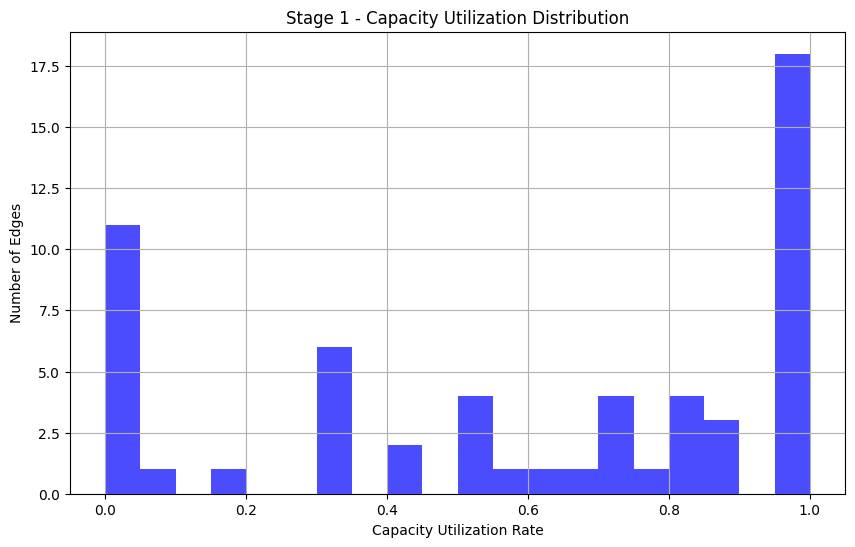

\STAGE 2 
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç51                    5,042
Başlangıç52                    2,375
Başlangıç56                    5,832
Başlangıç57                    3,436
Başlangıç67                      757
Başlangıç68                    6,199
Başlangıç70                    9,359
--------------------------------------------------
TOTAL                         33,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 193 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
 

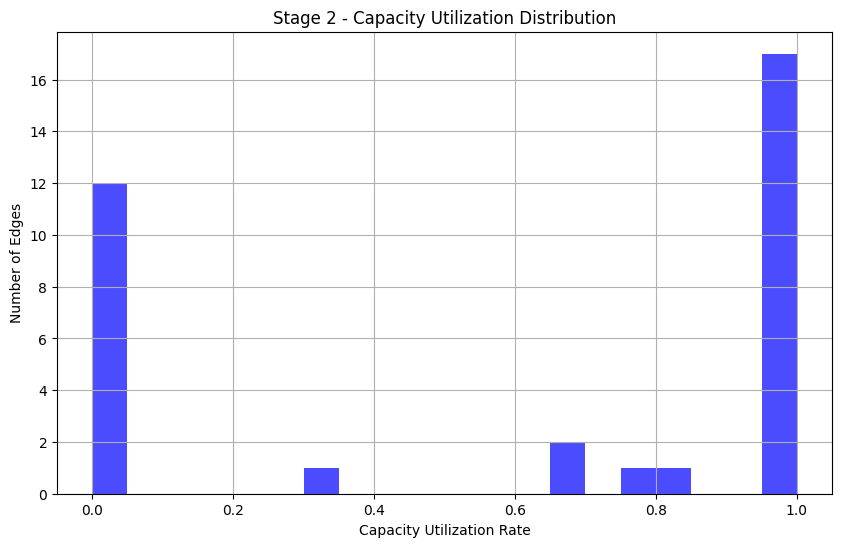

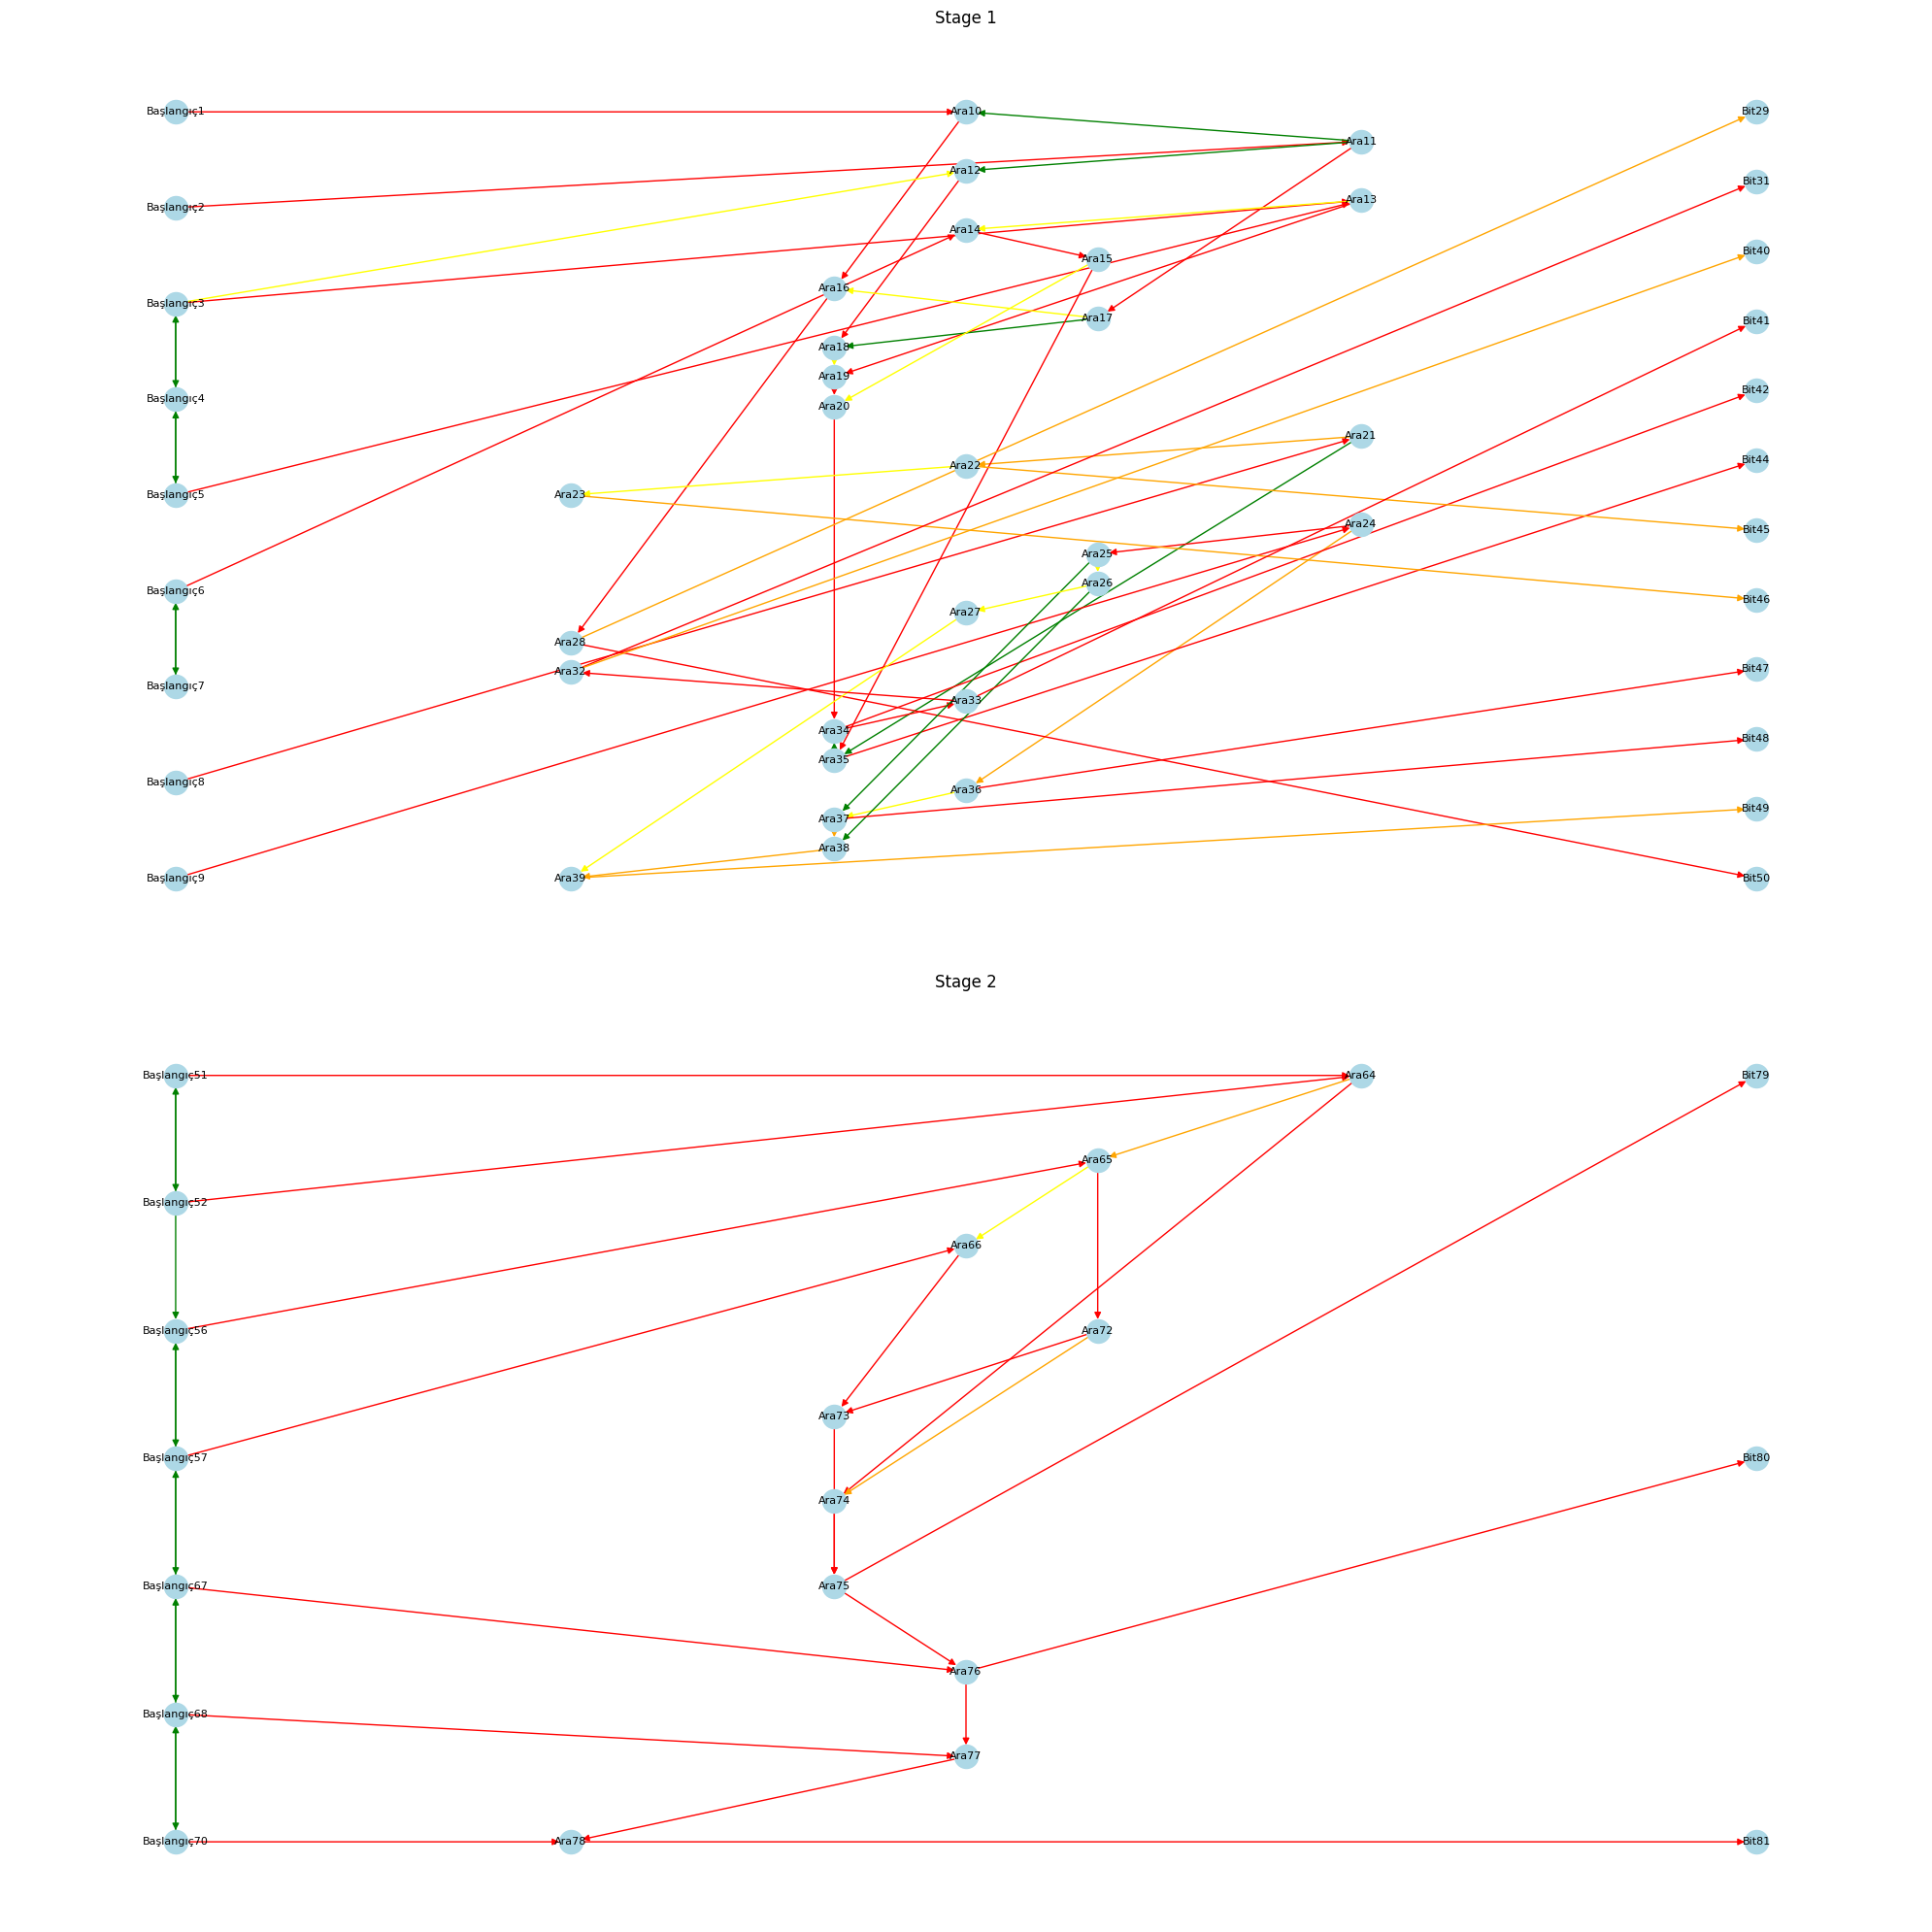

In [20]:
run_two_stage_optimization()

## Test Case 3

In [ ]:
edges = [
    ("Başlangıç1", "Ara1"),
    ("Başlangıç1", "Ara2"),
    ("Ara1", "Ara3"),
    ("Ara1", "Ara4"),
    ("Ara2", "Ara4"),
    ("Ara3", "Bit1"),
    ("Ara4", "Bit2")
]

travel_time = {
    ("Başlangıç1", "Ara1"): 100.0,
    ("Başlangıç1", "Ara2"): 120.0,
    ("Ara1", "Ara3"): 50.0,
    ("Ara1", "Ara4"): 60.0,
    ("Ara2", "Ara4"): 40.0,
    ("Ara3", "Bit1"): 80.0,
    ("Ara4", "Bit2"): 70.0
}
capacity = {
    ("Başlangıç1", "Ara1"): 10000,
    ("Başlangıç1", "Ara2"): 12000,
    ("Ara1", "Ara3"): 8000,
    ("Ara1", "Ara4"): 8000,
    ("Ara2", "Ara4"): 6000,
    ("Ara3", "Bit1"): 7000,
    ("Ara4", "Bit2"): 7000
}
passengers = {
    "Başlangıç1": 10000,
    "Ara1": 0,
    "Ara2": 0,
    "Ara3": 0,
    "Ara4": 0,
    "Bit1": 0,
    "Bit2": 0
}

In [ ]:
new_edges = [
    ('Başlangıç1', 'Başlangıç2'), ('Başlangıç1', 'Ara1'), ('Başlangıç1', 'Ara2'), 
    ('Başlangıç2', 'Başlangıç1'), ('Başlangıç2', 'Ara3'),
    ('Ara2', 'Ara3'), ('Ara2', 'Ara1'),
    ('Ara1', 'Bit1'), ('Ara3', 'Bit2'),
]
new_travel_time = {
    ('Başlangıç1', 'Başlangıç2'):0, ('Başlangıç1', 'Ara1'):12.4, ('Başlangıç1', 'Ara2'):120, 
    ('Başlangıç2', 'Başlangıç1'):0, ('Başlangıç2', 'Ara3'):12.4,
    ('Ara2', 'Ara3'):60, ('Ara2', 'Ara1'):30,
    ('Ara1', 'Bit1'):30, ('Ara3', 'Bit2'):40,
}
new_capacity = {
    ('Başlangıç1', 'Başlangıç2'):100000, ('Başlangıç1', 'Ara1'):1000, ('Başlangıç1', 'Ara2'):8000, 
    ('Başlangıç2', 'Başlangıç1'):100000, ('Başlangıç2', 'Ara3'):1000,
    ('Ara2', 'Ara3'):4000, ('Ara2', 'Ara1'):6000,
    ('Ara1', 'Bit1'):6000, ('Ara3', 'Bit2'):4000,
}
baslangic_noktalari = ['Başlangıç1', 'Başlangıç2']
new_passengers = {}

In [ ]:
run_two_stage_optimization()

## Test Case 10

In [59]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"),
    ("Başlangıç2", "Ara11"),
    ("Başlangıç3", "Ara13"),
    ("Başlangıç3", "Ara12"),
    ("Başlangıç3", "Başlangıç4"),
    ("Başlangıç4", "Başlangıç3"),
    ("Başlangıç4", "Başlangıç5"),
    ("Başlangıç5", "Ara13"),
    ("Başlangıç5", "Başlangıç4"),
    ("Başlangıç6", "Ara14"),
    ("Başlangıç6", "Başlangıç7"),
    ("Başlangıç7", "Başlangıç6"),
    ("Başlangıç8", "Ara21"),
    ("Başlangıç9", "Ara24"),

    # Intermediate connections
    ("Ara10", "Ara16"),
    ("Ara11", "Ara10"),
    ("Ara11", "Ara12"),
    ("Ara11", "Ara17"),
    ("Ara12", "Ara18"),
    ("Ara13", "Ara14"),
    ("Ara13", "Ara19"),
    ("Ara14", "Ara15"),
    ("Ara15", "Ara20"),
    ("Ara15", "Ara35"),
    ("Ara16", "Ara28"),
    ("Ara17", "Ara16"),
    ("Ara17", "Ara18"),
    ("Ara18", "Ara19"),
    ("Ara19", "Ara20"),
    ("Ara20", "Ara34"),
    ("Ara21", "Ara22"),
    ("Ara21", "Ara35"),
    ("Ara22", "Ara23"),
    ("Ara22", "Bit45"),
    ("Ara23", "Bit46"),
    ("Ara24", "Ara25"),
    ("Ara24", "Ara36"),
    ("Ara25", "Ara26"),
    ("Ara25", "Ara37"),
    ("Ara26", "Ara27"),
    ("Ara26", "Ara38"),
    ("Ara27", "Ara39"),
    ("Ara28", "Bit29"),
    ("Ara28", "Bit50"),
    ("Ara32", "Bit31"),
    ("Ara32", "Bit40"),
    ("Ara33", "Ara32"),
    ("Ara33", "Bit41"),
    ("Ara34", "Bit42"),
    ("Ara34", "Ara33"),
    ("Ara35", "Ara34"),
    ("Ara35", "Bit44"),
    ("Ara36", "Ara37"),
    ("Ara36", "Bit47"),
    ("Ara37", "Ara38"),
    ("Ara37", "Bit48"),
    ("Ara38", "Ara39"),
    ("Ara39", "Bit49"),
]

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 32.4,
    ("Başlangıç2", "Ara11"): 18,
    ("Başlangıç3", "Ara13"): 21.6,
    ("Başlangıç3", "Ara12"): 19.8,
    ("Başlangıç3", "Başlangıç4"): 0,
    ("Başlangıç4", "Başlangıç3"): 0,
    ("Başlangıç4", "Başlangıç5"): 0,
    ("Başlangıç5", "Ara13"): 37.8,
    ("Başlangıç5", "Başlangıç4"): 0,
    ("Başlangıç6", "Ara14"): 27,
    ("Başlangıç6", "Başlangıç7"): 0,
    ("Başlangıç7", "Başlangıç6"): 0,
    ("Başlangıç8", "Ara21"): 63,
    ("Başlangıç9", "Ara24"): 34.2,

    # Intermediate connections
    ("Ara10", "Ara16"): 43.2,
    ("Ara11", "Ara10"): 77.4,
    ("Ara11", "Ara12"): 68,
    ("Ara11", "Ara17"): 18,
    ("Ara12", "Ara18"): 27,
    ("Ara13", "Ara14"): 54,
    ("Ara13", "Ara19"): 34.2,
    ("Ara14", "Ara15"): 10.8,
    ("Ara15", "Ara20"): 21.6,
    ("Ara15", "Ara35"): 55.8,
    ("Ara16", "Ara28"): 176.4,
    ("Ara17", "Ara16"): 14,
    ("Ara17", "Ara18"): 12,
    ("Ara18", "Ara19"): 27,
    ("Ara19", "Ara20"): 66.6,
    ("Ara20", "Ara34"): 46.8,
    ("Ara21", "Ara22"): 41.4,
    ("Ara21", "Ara35"): 18,
    ("Ara22", "Ara23"): 32.4,
    ("Ara22", "Bit45"): 81,
    ("Ara23", "Bit46"): 77.4,
    ("Ara24", "Ara25"): 21.6,
    ("Ara24", "Ara36"): 25.2,
    ("Ara25", "Ara26"): 52.2,
    ("Ara25", "Ara37"): 25.2,
    ("Ara26", "Ara27"): 48.6,
    ("Ara26", "Ara38"): 25.2,
    ("Ara27", "Ara39"): 28.8,
    ("Ara28", "Bit29"): 50.4,
    ("Ara28", "Bit50"): 45,
    ("Ara32", "Bit31"): 19.8,
    ("Ara32", "Bit40"): 27,
    ("Ara33", "Ara32"): 10.8,
    ("Ara33", "Bit41"): 32.4,
    ("Ara34", "Bit42"): 45,
    ("Ara34", "Ara33"): 63,
    ("Ara35", "Ara34"): 48.6,
    ("Ara35", "Bit44"): 100.8,
    ("Ara36", "Ara37"): 21.6,
    ("Ara36", "Bit47"): 70.2,
    ("Ara37", "Ara38"): 18,
    ("Ara37", "Bit48"): 25,
    ("Ara38", "Ara39"): 50.4,
    ("Ara39", "Bit49"): 52.2,
}

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Ara10"): 4400,
    ("Başlangıç2", "Ara11"): 2200,
    ("Başlangıç3", "Ara13"): 2200,
    ("Başlangıç3", "Ara12"): 6600,
    ("Başlangıç3", "Başlangıç4"): 100000,
    ("Başlangıç4", "Başlangıç3"): 100000,
    ("Başlangıç4", "Başlangıç5"): 100000,
    ("Başlangıç5", "Ara13"): 4400,
    ("Başlangıç5", "Başlangıç4"): 100000,
    ("Başlangıç6", "Ara14"): 6600,
    ("Başlangıç6", "Başlangıç7"): 100000,
    ("Başlangıç7", "Başlangıç6"): 100000,
    ("Başlangıç8", "Ara21"): 4400,
    ("Başlangıç9", "Ara24"): 6600,

    # Intermediate connections
    ("Ara10", "Ara16"): 4400,
    ("Ara11", "Ara10"): 4400,
    ("Ara11", "Ara12"): 4400,
    ("Ara11", "Ara17"): 2200,
    ("Ara12", "Ara18"): 2200,
    ("Ara13", "Ara14"): 6600,
    ("Ara13", "Ara19"): 4400,
    ("Ara14", "Ara15"): 8800,
    ("Ara15", "Ara20"): 4400,
    ("Ara15", "Ara35"): 6600,
    ("Ara16", "Ara28"): 6600,
    ("Ara17", "Ara16"): 4400,
    ("Ara17", "Ara18"): 6600,
    ("Ara18", "Ara19"): 6600,
    ("Ara19", "Ara20"): 6600,
    ("Ara20", "Ara34"): 8800,
    ("Ara21", "Ara22"): 6600,
    ("Ara21", "Ara35"): 4400,
    ("Ara22", "Ara23"): 6600,
    ("Ara22", "Bit45"): 2200,
    ("Ara23", "Bit46"): 4400,
    ("Ara24", "Ara25"): 2200,
    ("Ara24", "Ara36"): 6600,
    ("Ara25", "Ara26"): 4400,
    ("Ara25", "Ara37"): 6600,
    ("Ara26", "Ara27"): 4400,
    ("Ara26", "Ara38"): 4400,
    ("Ara27", "Ara39"): 4400,
    ("Ara28", "Bit29"): 4400,
    ("Ara28", "Bit50"): 4400,
    ("Ara32", "Bit31"): 2200,
    ("Ara32", "Bit40"): 2200,
    ("Ara33", "Ara32"): 4400,
    ("Ara33", "Bit41"): 2200,
    ("Ara34", "Bit42"): 4400,
    ("Ara34", "Ara33"): 6600,
    ("Ara35", "Ara34"): 6600,
    ("Ara35", "Bit44"): 6600,
    ("Ara36", "Ara37"): 6600,
    ("Ara36", "Bit47"): 2200,
    ("Ara37", "Ara38"): 2200,
    ("Ara37", "Bit48"): 2200,
    ("Ara38", "Ara39"): 2200,
    ("Ara39", "Bit49"): 4400,
}

passengers = {
    "Başlangıç1": 3000,
    "Başlangıç2": 3000,
    "Başlangıç3": 2000,
    "Başlangıç4": 0,
    "Başlangıç5": 3000,
    "Başlangıç6": 3000,
    "Başlangıç7": 0,
    "Başlangıç8": 4000,
    "Başlangıç9": 4000,

    "Ara10": 0, "Ara11": 0, "Ara12": 0, "Ara13": 0, "Ara14": 0,
    "Ara15": 0, "Ara16": 0, "Ara17": 0, "Ara18": 0, "Ara19": 0,
    "Ara20": 0, "Ara21": 0, "Ara22": 0, "Ara23": 0, "Ara24": 0,
    "Ara25": 0, "Ara26": 0, "Ara27": 0, "Ara28": 0, "Bit29": 0,
    "Bit30": 0, "Bit31": 0, "Ara32": 0, "Ara33": 0, "Ara34": 0,
    "Ara35": 0, "Ara36": 0, "Ara37": 0, "Ara38": 0, "Ara39": 0,
    "Bit40": 0, "Bit41": 0, "Bit42": 0, "Bit43": 0, "Bit44": 0,
    "Bit45": 0, "Bit46": 0, "Bit47": 0, "Bit48": 0, "Bit49": 0,
    "Bit50": 0
}

In [60]:
# Yeni ağ yapısı
new_edges = [
    ('Başlangıç51', 'Başlangıç52'), ('Başlangıç51', 'Ara64'), 
    ('Başlangıç52', 'Başlangıç51'), ('Başlangıç52', 'Başlangıç56'), ('Başlangıç52', 'Ara64'),
    ('Başlangıç56', 'Başlangıç57'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç56', 'Ara65'),
    ('Başlangıç57', 'Başlangıç67'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç57', 'Ara66'),
    ('Başlangıç67', 'Başlangıç57'), ('Başlangıç67', 'Başlangıç68'), ('Başlangıç67', 'Ara76'),
    ('Başlangıç68', 'Başlangıç67'), ('Başlangıç68', 'Başlangıç70'), ('Başlangıç68', 'Ara77'),
    ('Başlangıç70', 'Başlangıç68'), ('Başlangıç70', 'Ara78'),
    ('Ara64', 'Ara65'), ('Ara64', 'Ara74'),
    ('Ara65', 'Ara66'), ('Ara65', 'Ara72'),
    ('Ara66', 'Ara73'), 
    ('Ara72', 'Ara73'), ('Ara72', 'Ara74'),
    ('Ara73', 'Ara75'),
    ('Ara74', 'Ara75'),
    ('Ara75', 'Ara76'), ('Ara75', 'Bit79'),
    ('Ara76', 'Ara77'), ('Ara76', 'Bit80'),
    ('Ara77', 'Ara78'),
    ('Ara78', 'Bit81'),
]

# Yeni seyahat süreleri
new_travel_time = {
    ('Başlangıç51', 'Başlangıç52'):0, ('Başlangıç51', 'Ara64'):90, 
    ('Başlangıç52', 'Başlangıç51'):0, ('Başlangıç52', 'Başlangıç56'):0, ('Başlangıç52', 'Ara64'): 36,
    ('Başlangıç56', 'Başlangıç57'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç56', 'Ara65'): 27,
    ('Başlangıç57', 'Başlangıç67'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç57', 'Ara66'): 34.20,
    ('Başlangıç67', 'Başlangıç57'):0, ('Başlangıç67', 'Başlangıç68'):0, ('Başlangıç67', 'Ara76'): 50.4,
    ('Başlangıç68', 'Başlangıç67'):0, ('Başlangıç68', 'Başlangıç70'):0, ('Başlangıç68', 'Ara77'): 68.4,
    ('Başlangıç70', 'Başlangıç68'):0, ('Başlangıç70', 'Ara78'): 72.00,
    ('Ara64', 'Ara65'): 86.4, ('Ara64', 'Ara74'): 90,
    ('Ara65', 'Ara66'): 79.2, ('Ara65', 'Ara72'): 14.4,
    ('Ara66', 'Ara73'): 23.4, 
    ('Ara72', 'Ara73'): 79.2, ('Ara72', 'Ara74'): 14.4,
    ('Ara73', 'Ara75'): 23.4,
    ('Ara74', 'Ara75'): 79.2,
    ('Ara75', 'Ara76'): 52.2, ('Ara75', 'Bit79'): 39.6,
    ('Ara76', 'Ara77'): 73.8, ('Ara76', 'Bit80'): 55.8,
    ('Ara77', 'Ara78'): 32.4,
    ('Ara78', 'Bit81'): 79.2,
}

# Yeni kapasiteler
new_capacity = {
    ('Başlangıç51', 'Başlangıç52'):1000000, ('Başlangıç51', 'Ara64'):2200, 
    ('Başlangıç52', 'Başlangıç51'):1000000, ('Başlangıç52', 'Başlangıç56'):1000000, ('Başlangıç52', 'Ara64'): 4400,
    ('Başlangıç56', 'Başlangıç57'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç56', 'Ara65'): 6600,
    ('Başlangıç57', 'Başlangıç67'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç57', 'Ara66'): 4400,
    ('Başlangıç67', 'Başlangıç57'):1000000, ('Başlangıç67', 'Başlangıç68'):1000000, ('Başlangıç67', 'Ara76'): 6600,
    ('Başlangıç68', 'Başlangıç67'):1000000, ('Başlangıç68', 'Başlangıç70'):1000000, ('Başlangıç68', 'Ara77'): 2200,
    ('Başlangıç70', 'Başlangıç68'):1000000, ('Başlangıç70', 'Ara78'): 6600,
    ('Ara64', 'Ara65'): 4400, ('Ara64', 'Ara74'): 4400,
    ('Ara65', 'Ara66'): 13200, ('Ara65', 'Ara72'): 6600,
    ('Ara66', 'Ara73'): 8800, 
    ('Ara72', 'Ara73'): 2200, ('Ara72', 'Ara74'): 4400,
    ('Ara73', 'Ara75'): 11000,
    ('Ara74', 'Ara75'): 6600,
    ('Ara75', 'Ara76'): 6600, ('Ara75', 'Bit79'): 11000,
    ('Ara76', 'Ara77'): 2200, ('Ara76', 'Bit80'): 11000,
    ('Ara77', 'Ara78'): 4400,
    ('Ara78', 'Bit81'): 11000,
}

# Yeni yolcu dağılımı - Daha güvenli yöntem
baslangic_noktalari = ['Başlangıç51', 'Başlangıç52', 'Başlangıç56', 'Başlangıç57', 'Başlangıç67', 'Başlangıç68', 'Başlangıç70']


STAGE 1 -
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç1                     3,000
Başlangıç2                     3,000
Başlangıç3                     2,000
Başlangıç5                     3,000
Başlangıç6                     3,000
Başlangıç8                     4,000
Başlangıç9                     4,000
--------------------------------------------------
TOTAL                         22,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 194 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
 

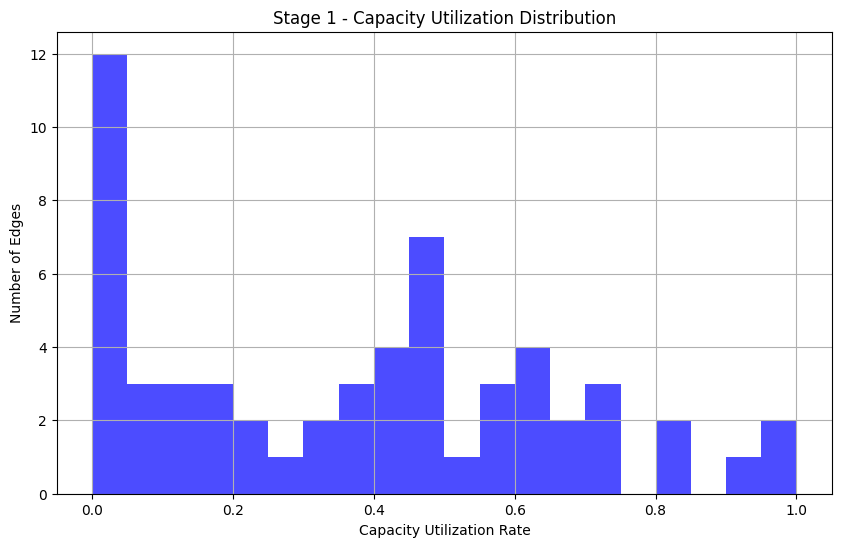

\STAGE 2 
-------------------------

========= PASSENGER DISTRIBUTION AT START POINTS =========
--------------------------------------------------
Start Point          Passenger Count
--------------------------------------------------
Başlangıç51                    3,955
Başlangıç52                    1,559
Başlangıç56                      202
Başlangıç57                       65
Başlangıç67                    8,085
Başlangıç68                    4,985
Başlangıç70                    3,149
--------------------------------------------------
TOTAL                         22,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=4

==> Warning: Treating 0 binary and 193 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
 

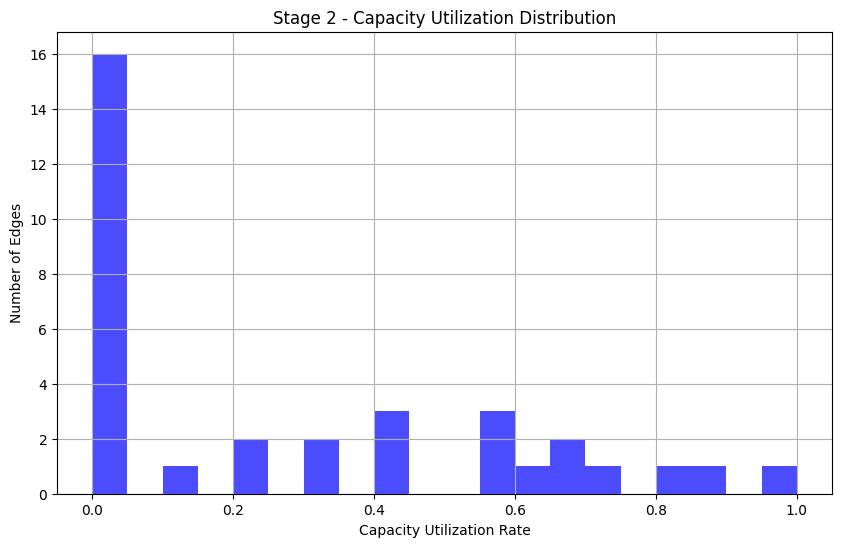

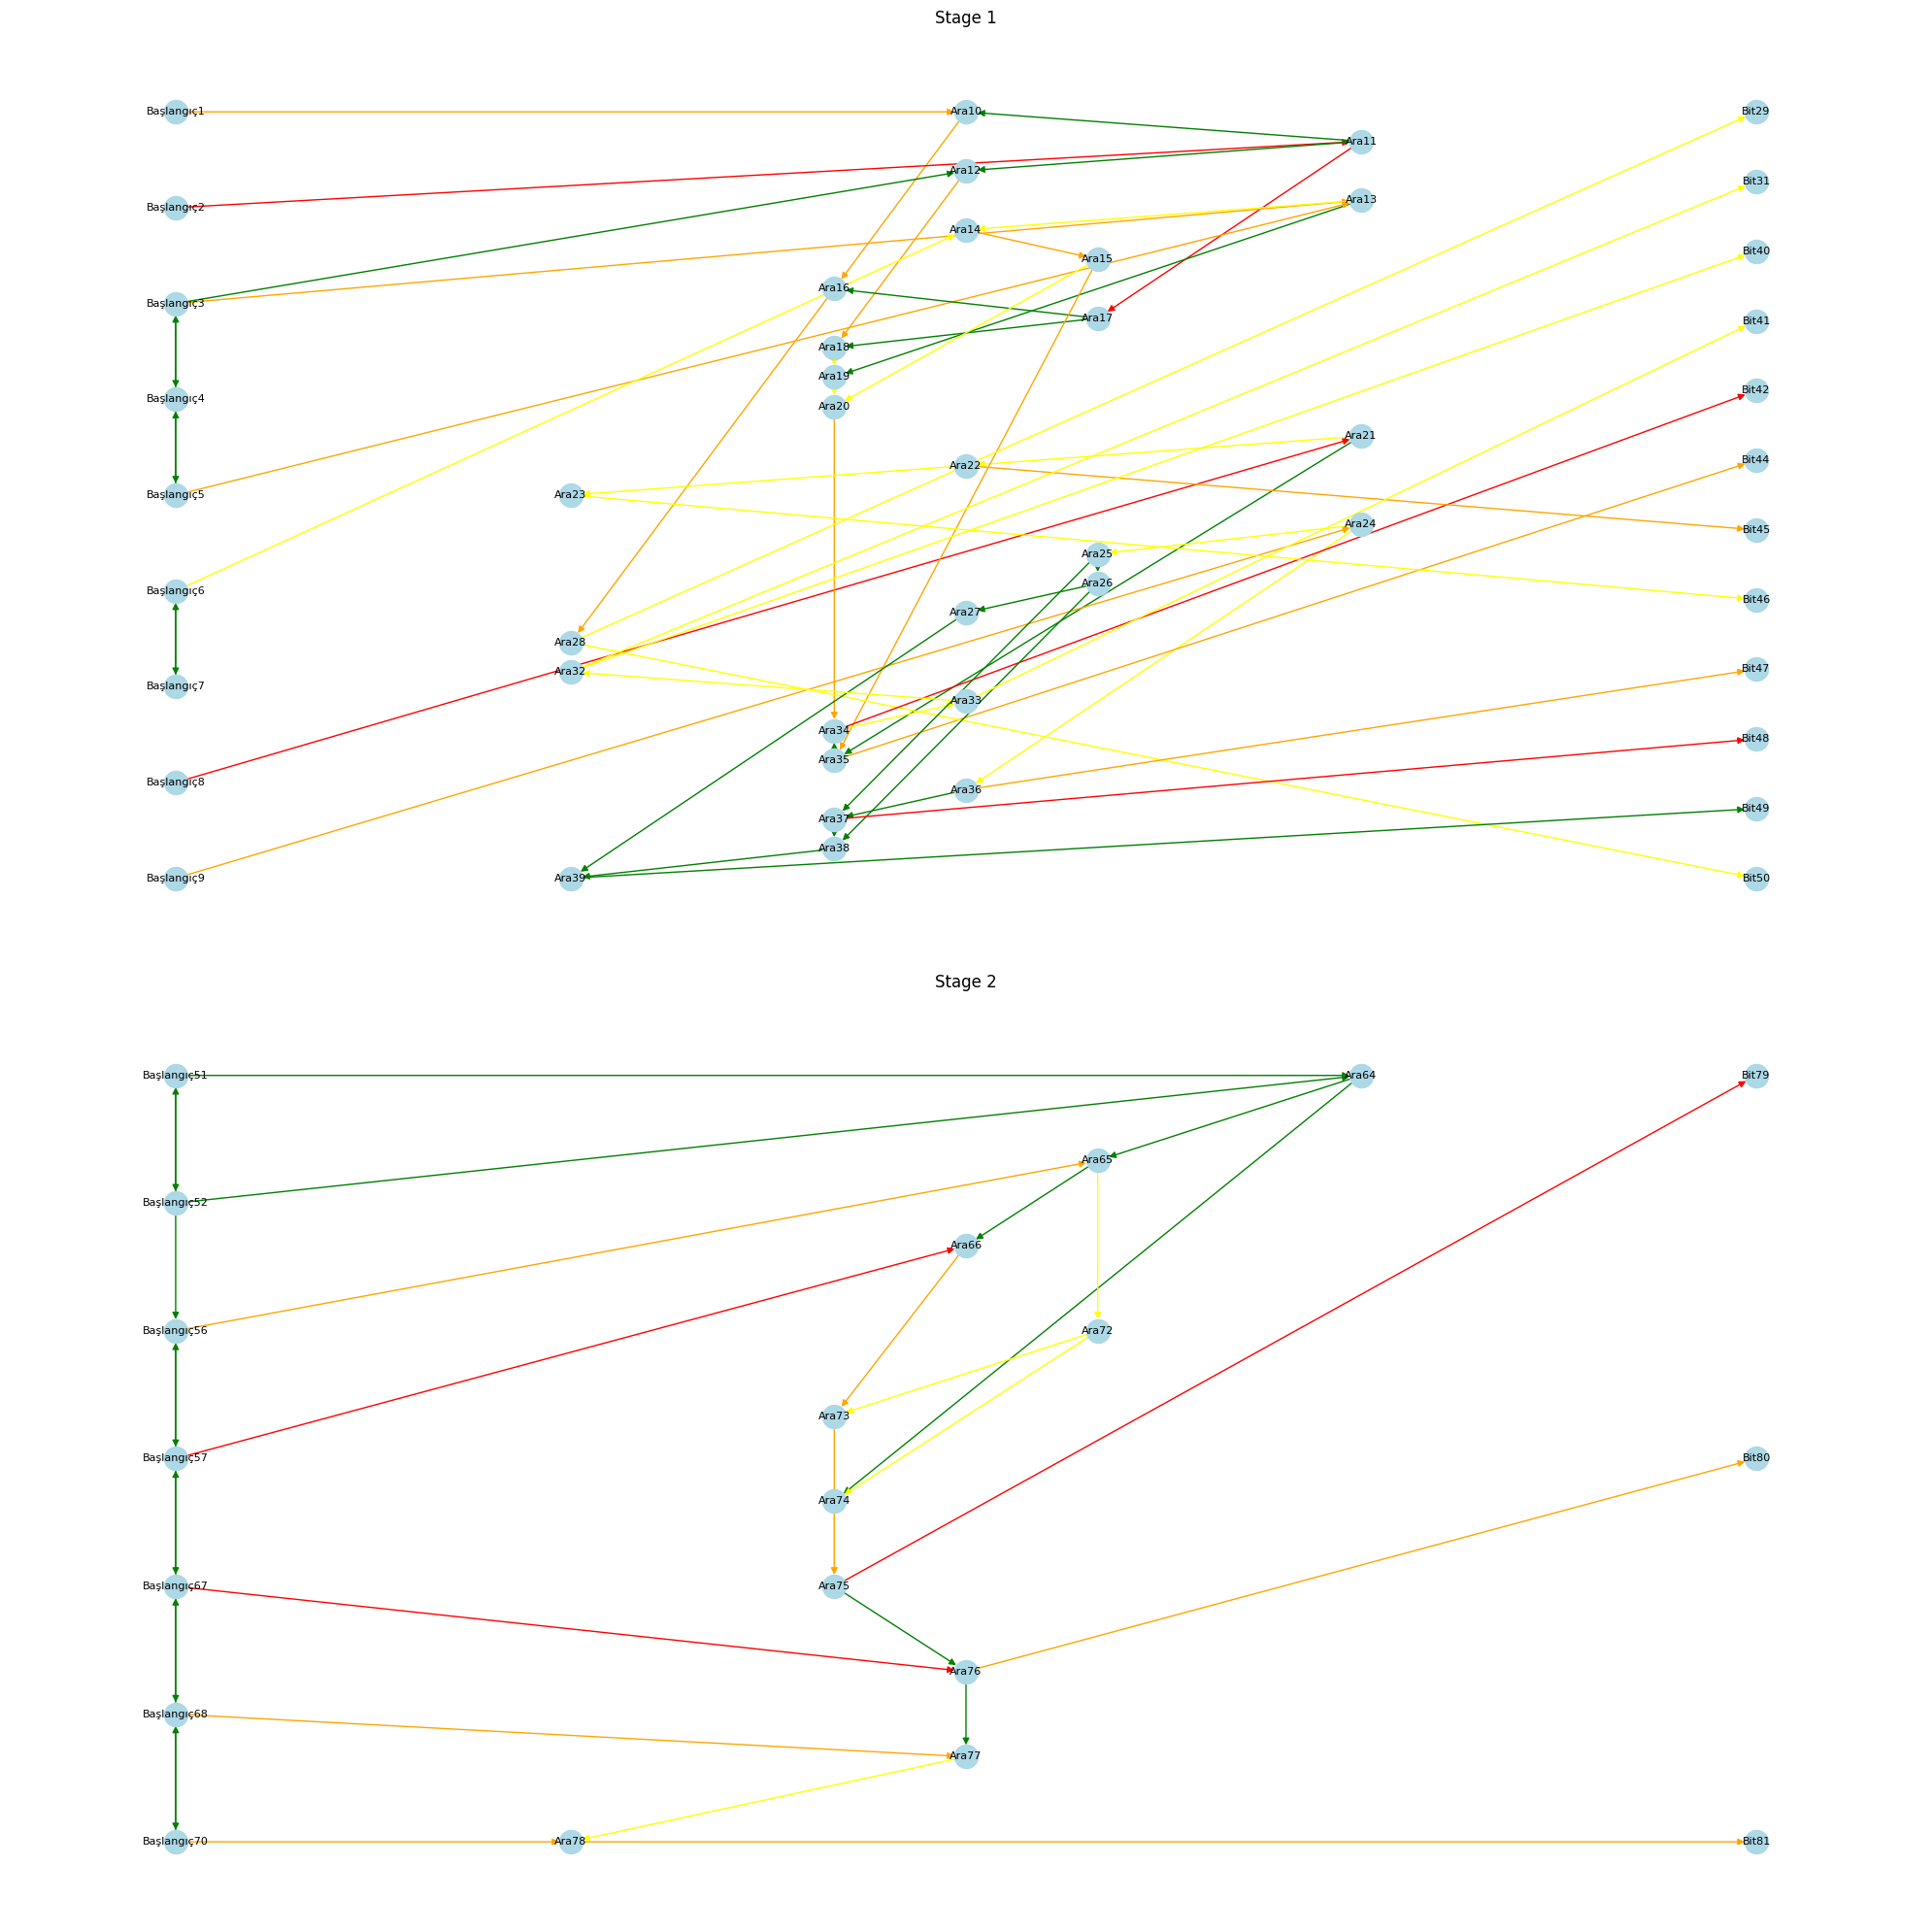

In [61]:
run_two_stage_optimization()